In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import os
import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:

def matrix_riccati_ode(t, S, H, M, D_inv, C):
    S = S.reshape((H.shape[0], H.shape[1]))
    dS_dt = -2 * H.T @ S + S @ M @ D_inv @ M.T @ S - C
    return dS_dt.reshape(-1)

class LQR:
    def __init__(self, H, M, sigma, C, R, D, T):
        self.H = H
        self.M = M
        self.sigma = sigma
        self.C = C
        self.R = R
        self.D = D
        self.T = T

    def solve(self, t, t_eval = None):
        D_inv = np.linalg.inv(self.D)
        if t == self.T:
            return None, None
        if t is None:
            t = 0
        if t_eval is None:
            t_eval = np.linspace(self.T, t, 101)
        sol = solve_ivp(matrix_riccati_ode, (self.T, t), self.R.reshape(-1), t_eval = t_eval, method='RK45', args=(self.H, self.M, D_inv, self.C))
        return sol.t, sol.y.reshape((-1, self.H.shape[0], self.H.shape[1]))  # Reshape solution to matrix form

    def getValue(self, ts, data):
        batch_size = data.shape[0]
        values = torch.zeros((batch_size, 1))
        for i in range(batch_size):
            t = ts[i]
            x = data[i][0].numpy()
            n = 101
            ts, sols = self.solve(t, np.linspace(self.T, t, n))
            values[i][0] = x.T @ sols[-1] @ x
            for sol in sols:
                values[i][0] += abs(self.T - t) / n * np.trace(self.sigma @ self.sigma.T @ sol)
        return values

    def getMarkovControl(self, ts, data):
        batch_size = data.shape[0]
        values = torch.zeros((batch_size, 2))
        for i in range(batch_size):
            t = ts[i]
            x = data[i][0].numpy()
            n = 101
            ts, sols = self.solve(t, np.linspace(self.T, t, n))
            values[i] = torch.from_numpy(-self.D @ self.M.T @ sols[-1] @ x)
        return values

    
    def runMonteCarlo(self, num_steps, num_samples, x):
        res = []
        dt = self.T / num_steps
        ts = np.linspace(0, self.T, num_steps)
        for i in range(num_samples):
            cur_x = np.array(x).reshape(-1,1)
            for j in range(num_steps - 1):
                increments = np.random.normal(0, 1, (1,2)).T
                _, S_tn = self.solve(ts[j])
                S_tn = S_tn[-1]
                cur_x = cur_x + dt * (self.H @ cur_x - self.M @ self.D @ S_tn @ cur_x) + self.sigma @ increments
            res.append(cur_x)
        return res


In [4]:
# Example usage:
H = np.array([[0, 1], [0, 0]])
M = np.array([[1, 0], [0, 1]])
D = np.array([[1, 0], [0, 1]])
T = 10
R = np.array([[1, 0], [0, 1]])
C = np.array([[0, 0], [0, 0]])
sigma = np.array([[0.2, 0], [0, 0.4]])
lqr = LQR(H, M, sigma, C, R, D, T)

t, p = lqr.solve(1, [10, 9, 8,7,6,5,4,3,2,1])

In [5]:
ts = torch.tensor([1, 2])
x = torch.tensor([[[2,1]], [[3,2]]])

In [6]:
print(t.shape)

(10,)


In [6]:
lqr.getValue(ts, x)

tensor([[ 1.5519],
        [22.9790]])

In [7]:
lqr.getMarkovControl(ts, x)

tensor([[-0.3080, -0.3024],
        [-4.5970, -4.5894]])

From the above code, we define the class LQR with attribute 'H, M, sigma, C, R, D, T', which is mentioned in the definition of LQR. The class has three methods - solve, getValue, getMarkovControl. 'Solve' will solve the associated Ricatti ODE on a time grid. 'getValue' will return the control problem value $v(t,x)$. 'getMarkovControl' will return the Markov control function.

We can choose MSE for error measure and we write following codes to show log-log plot.

In [ ]:


# Set number of Monte Carlo samples
num_samples = 10000

# Set different numbers of time steps to simulate
num_steps_list = [1, 10, 50, 100, 500, 1000, 5000]

# Initialize list to store MSE for each number of time steps
mse_list = []

# initial value of x
x = [1, 2]

# Loop over different numbers of time steps and compute MSE
for num_steps in num_steps_list:
    # Run Monte Carlo simulation
    # Here, we assume that the simulation returns the estimated value function as a numpy array
    # and the true value function as a dictionary with state-value pairs
    x_rets = lqr.runMonteCarlo(num_steps, num_samples, x)
    _, x_true = lqr.solve(0)
    x_true = x_true[-1]
    
    # Compute MSE
    mse = np.mean([np.linalg.norm(x_ret - x_true)**2 for x_ret in x_rets])
    
    # Append MSE to list
    mse_list.append(mse)


plt.loglog(num_steps_list, mse_list, '-o')
plt.xlabel('Number of time steps')
plt.ylabel('Mean squared error')
plt.show()


In [ ]:
# Set number of Monte Carlo samples
num_samples_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

# Set different numbers of time steps to simulate
num_steps = 5000

# Initialize list to store MSE for each number of time steps
mse_list = []

# initial value of x
x = [1, 2]

# Loop over different numbers of time steps and compute MSE
for num_samples in num_samples_list:
    # Run Monte Carlo simulation
    # Here, we assume that the simulation returns the estimated value function as a numpy array
    # and the true value function as a dictionary with state-value pairs
    x_rets = lqr.runMonteCarlo(num_steps, num_samples, x)
    _, x_true = lqr.solve(0)
    x_true = x_true[-1]
    
    # Compute MSE
    mse = np.mean([np.linalg.norm(x_ret - x_true)**2 for x_ret in x_rets])
    
    # Append MSE to list
    mse_list.append(mse)


plt.loglog(num_steps_list, mse_list, '-o')
plt.xlabel('Number of samples')
plt.ylabel('Mean squared error')
plt.show()


Exercise 2

In [8]:
import torch
from torch import nn, optim
import numpy as np
from tqdm import tqdm

class DGM_Layer(nn.Module):
    """ 
    Defines a PyTorch module DGM_Layer which implements a single layer of a deep gated network.
    The activation parameter specifies the activation function to be used in the layer
    """
    def __init__(self, dim_x, dim_S, activation='Tanh'):


        super(DGM_Layer, self).__init__()
        

        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))
            
        
        # The module has four gates
        # Z gate (update gate): controls how much of the previous state to keep and how much of the new input to include in the current state. 
        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        # G gate (reset gate): controls how much of the previous state to forget and how much of the new input to remember. 
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        # R gate (reset signal): controls how much of the input to use to modify the current state.
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        # H gate (hidden state): produces a candidate hidden state that can be added to the current state. 
        self.gate_H = self.layer(dim_x+dim_S, dim_S)
            
    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l
    


    def forward(self, x, S):
        # concatenates  input 'x' and the hidden state 'S' along the feature dimension
        x_S = torch.cat([x,S],1)
        
        
        # passes the concatenated tensor through each of the four gates. 
        Z = self.gate_Z(x_S) # how much of the new state to keep
        G = self.gate_G(x_S) # how much proportion of the previous state to keep
        R = self.gate_R(x_S) # the proportion of the input to use to modify the current state.

        
        input_gate_H = torch.cat([x, S*R],1) # 'R*S' is modified state
        H = self.gate_H(input_gate_H)  #  candidate hidden state, and is the amount of information from the current input to add to the new state

        
        # The resulting tensors are then combined to compute the new hidden state S for the next time step, which is returned as output.
        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        """
        dim_x is the dimension of the input tensor,
        dim_S is the number of hidden units in each of the three DGM_Layer objects,
        activation is the activation function used in the hidden layers, which can be ReLU, Tanh, Sigmoid, or LogSigmoid.
        The constructor initializes the class variables using the arguments, and creates the layers of the neural network.
        """
        super(Net_DGM, self).__init__()
      
        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation)
        # The input_layer is a linear layer followed by an activation function, which takes a concatenation of t and x as input
        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        """
        DGM1, DGM2, and DGM3 are three layers of the Deep Gaussian Process (DGP) model. 
        They are initialized with 
        dim_x+1 as input dimension (where the +1 accounts for the time input t), 
        dim_S as output dimension, and the activation function specified in the constructor.
        """
        self.output_layer = nn.Linear(dim_S, 1)
        # The output_layer is a linear layer that takes the output from the last DGM layer as input and produces a single output value.
        
    def forward(self,t,x):
        # The forward method defines the forward pass of the neural network, which takes two input tensors t and x and returns a single output tensor.
        # t and x are concatenated along the second dimension using torch.cat to create a single input tensor.
        tx = torch.cat([t,x], 1)

        # This input tensor is then passed through the input_layer to obtain S1, which is then passed through DGM1, DGM2, and DGM3 to obtain S4.
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)

        # Finally, S4 is passed through the output_layer to obtain the output of the neural network, which is returned.
        output = self.output_layer(S4)
        return output


      
        

In [11]:
T = 1 # time horizon
hidden_size = 100 # hidden layer size = 100
lr = 0.01 # the learning rate for the optimizer
num_epochs = 10000 # the number of iterations the optimizer will perform to train the neural network

net = Net_DGM(2, hidden_size)
# neural network is defined using the Net_DGM class with input dimension of 2 

optimizer = optim.Adam(net.parameters(), lr=lr)
# initializes the Adam optimizer with the learning rate lr and the parameters of the neural network net. 
# The net.parameters() method returns an iterable of all the trainable parameters in the neural network net. 

criterion = nn.MSELoss()
# The mean squared error (MSE) loss function is defined using the nn.MSELoss() class.

losses = [] # empty list prepared for value of the loss
for epoch in tqdm(range(num_epochs)):
    #  t is a randomly selected value between 0 and T, which can be used as a time parameter for some stochastic process.
    t = np.random.uniform(0, T)
    # Two random numbers between -3 and 3 are generated and stored in the list x
    x = [np.random.uniform(-3, 3), np.random.uniform(-3, 3)]
    # An LQR object is created
    lqr = LQR(H, M, sigma, C, R, D, 1)

    # true value of the solution to the LQR problem
    y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))
    # optimizer's gradient is reset to zero
    optimizer.zero_grad()
    # predict the value of the solution to the LQR problem at time t and state x
    y_pred = net(torch.tensor([[t]], dtype=torch.float32), torch.tensor([x]))

    # The MSE loss between the predicted value and the true value
    loss = criterion(y_pred, y_true)

    # gradients of the neural network's parameters
    loss.backward()
    # optimizer takes a step in the negative direction of the gradients
    optimizer.step()

    losses.append(loss.item())


  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/30/5npdvf4d7mb7d1df8ndd9dmm0000gn/T/ipykernel_22462/2836287028.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))
100%|██████████| 10000/10000 [01:01<00:00, 161.38it/s]


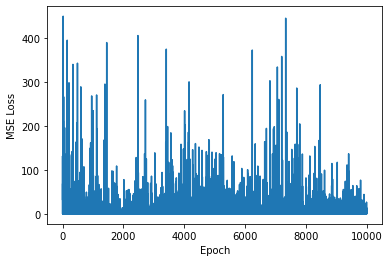

In [12]:
plt.plot(losses, '-')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [13]:
class FFN(nn.Module):
    """ 
    define a fully-connected feed-forward neural network.
    sizes: a list of integers specifying the number of neurons in each layer of the neural network.
    activation: an activation function to apply between hidden layers. By default, the ReLU activation function is used.
    output_activation: an activation function to apply to the output layer. By default, the identity function is used.
    batch_norm: a boolean flag indicating whether or not to apply batch normalization between layers. By default, this flag is set to False.
    """

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()
        
        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers)

    


    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    """ 
    used to freeze and unfreeze the weights of the neural network, respectively. 
    When the weights are frozen, their gradients are not computed during backpropagation, effectively making them untrainable. 
    When the weights are unfrozen, their gradients are computed during backpropagation and the weights can be trained.
    """


    def forward(self, x):
        return self.net(x)
        # method is used to define the forward pass of the neural network. 
        # The output tensor of the last layer is returned as the output of the neural network.

In [ ]:
net = FFN([3, 100, 100, 2]) # A feedforward neural network is defined
optimizer = optim.Adam(net.parameters(), lr=lr) # Adam optimizer is defined with the learning rate specified
criterion = nn.MSELoss() # A mean squared error loss function is defined.

losses = []
for epoch in tqdm(range(num_epochs)):
    t = np.random.uniform(0, T)
    x = [np.random.uniform(-3, 3), np.random.uniform(-3, 3)]

    # obtain the true value of the output at time t given the initial state x.
    lqr = LQR(H, M, sigma, C, R, D, 1)
    y_true = torch.tensor(lqr.getValue(torch.tensor([t]), torch.tensor([[x]], dtype=torch.float32)))

    # reset the gradients in the optimizer to zero
    optimizer.zero_grad()

    # Concatenate two tensors horizontally and pass through the neural network in a single operation
    # ensure that the values of t and x are processed together by the neural network, rather than separately.
    tx = torch.cat([torch.tensor([[t]], dtype=torch.float32), torch.tensor([x])], 1)
    # use the neural network to predict the value of the solution to the LQR problem at time 't' and state 'x'
    y_pred = net(tx)

    # loss between the predicted value and the true value
    loss = criterion(y_pred, y_true)
    # gradients of the neural network's parameters
    loss.backward()

    # update the model parameters to optimize the model parameters such that the loss function is minimized.
    optimizer.step()
    losses.append(loss.item())

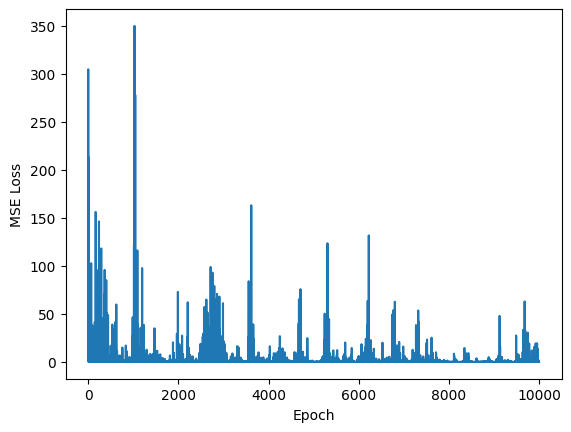

In [9]:
plt.plot(losses, '-')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

## Exercise 3

In [15]:
def get_gradient(output, x):
    """ 
    The function takes two arguments: output and x, which are both PyTorch tensors.
    'output': This is the tensor that we want to compute the gradient of.
    'x': This is the tensor with respect to which we want to compute the gradient.
    """ 
    grad = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True, retain_graph=True, only_inputs=True)[0]
    # returns the computed gradient tensor.
    return grad

def get_laplacian(grad, x):
    """
    The function takes two arguments: grad and x, which are both PyTorch tensors.
    'grad' represents the gradient tensor of some function with respect to x.
    'x' represents the tensor with respect to which we want to compute the Laplacian of the function.
    """
    hess = [] # empty list hess that will store the Hessian matrix for each dimension of x.
    for d in range(x.shape[1]):
        v = grad[:,d].view(-1,1) # This is a tensor that represents the gradient of a single component of grad with respect to x.
        # calculate the Hessian matrices for each dimension of x, using torch.ones_like(v) to initialize the gradients to a tensor of ones with the same shape as the gradient tensor.
        grad2 = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v), only_inputs=True, create_graph=True, retain_graph=True)[0]
        hess.append(grad2)
    return torch.cat(hess, 1)

class PDE_DGM(nn.Module):
    """ 
    Defines a PyTorch module called PDE_DGM, which stands for "partial differential equation deep Galerkin method". 
    This module is used to solve partial differential equations (PDEs) using deep learning.
    """
    def __init__(self, d: int, hidden_dim: int, H, M, sigma, C, R, D, ts: torch.Tensor=None, device: str='cpu'):
        # d: an integer representing the dimensionality of the PDE.
        # hidden_dim: an integer representing the number of hidden units in the neural network.
        # H, M, sigma, C, R, D: tensors representing the coefficients of the PDE.
        # ts: a tensor representing the time points at which the PDE should be solved.
        # device: a string representing the device (e.g., "cpu" or "cuda") on which to perform the computations.
        super().__init__()
        self.d = d 
        self.net_dgm = Net_DGM(d, hidden_dim, activation='Tanh')
        self.H = torch.tensor(H, device=device)
        self.M = torch.tensor(M, device=device)
        self.sigma = torch.tensor(sigma, device=device)
        self.C = torch.tensor(C, device=device)
        self.R = torch.tensor(R, device=device)
        self.D = torch.tensor(D, device=device)
        self.alpha = torch.tensor([[1], [1]], device=device)
        self.ts = ts

    def fit(self, max_updates: int, batch_size: int, device):
        """ 
        The fit method performs gradient descent on the neural network parameters 
        to minimize the mean squared error (MSE) between the predicted solution to the PDE and the actual solution.
        """
        optimizer = torch.optim.Adam(self.net_dgm.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = (10000,),gamma=0.1)
        loss_fn = nn.MSELoss()
    
        pbar = tqdm(total=max_updates) # initializes a new progress bar with a maximum number of updates specified by max_updates. 
        
        loss_value = []

        # generates a random set of input points in the domain of the PDE, 
        # and evaluates the neural network at these points to obtain an approximate solution to the PDE.
        for it in range(max_updates):
            optimizer.zero_grad() # set all to zero
            # generates a random tensor of shape (batch_size, self.d) with elements drawn uniformly from the range [-3, 3). 
            # ensures that the elements of the tensor are centered around zero
            input_domain = 6 * torch.rand(batch_size, self.d, device=device, requires_grad=True) - 3
            t0, T = self.ts[0], self.ts[-1] # time domain for the problem is defined by the range between t0 and T.
            # generates a tensor of random numbers between 0 and 1 of shape (batch_size, 1) and assigns it to t. 
            t = t0 + T*torch.rand(batch_size, 1, device=device, requires_grad=True)

            # t_T is a tensor of shape (batch_size, 1) containing the value of T for each batch element.
            t_T = torch.ones(batch_size, 1, device=device) * T 

            # outputs of the neural network at t and T
            u_of_tx = self.net_dgm(t, input_domain)
            u_of_Tx = self.net_dgm(t_T, input_domain)

            # the gradients of the neural network outputs with respect to the inputs 'input_domain' and 't'
            grad_u_x = get_gradient(u_of_tx,input_domain)
            grad_u_t = get_gradient(u_of_tx, t)

            laplacian = get_laplacian(grad_u_x, input_domain)

            # a target in the loss calculation for the PDE equation and boundary conditions
            target = torch.zeros_like(u_of_tx)
            R1, R2 = 0, 0
            eqn = []
            boundary = []

            for i in range(laplacian.shape[0]):
                x = laplacian[i]
                temp_x = x.cpu().detach().numpy().reshape(2,2)
                x_i = input_domain[i].cpu().detach().numpy()
                grad_u_x_i = grad_u_x[i].cpu().detach().numpy()
                alpha_np = self.alpha.cpu().numpy()
                # for each sample in the batch, computes the temporary value for the PDE by evaluating the equation
                temp_value = abs(grad_u_t[i].cpu().detach().numpy()
                         + 1/2*np.trace(self.sigma.cpu().numpy() @ self.sigma.cpu().numpy().T @ temp_x)
                         + grad_u_x_i.T @ self.H.cpu().numpy() @ x_i
                         + grad_u_x_i.T @ self.M.cpu().numpy() @ alpha_np
                         + grad_u_x_i.T @ self.M.cpu().numpy() @ alpha_np
                         + x_i.T @ self.C.cpu().numpy() @ x_i
                         + alpha_np.T @ self.D.cpu().numpy() @ alpha_np
                        )**2
                # appends this residual value to the list eqn.
                eqn.append(temp_value.tolist()[0])

                # computes the temporary value for the boundary condition by evaluating the equation:
                temp_value = abs(u_of_Tx[i].cpu().detach().numpy() - x_i.T @ self.R.cpu().numpy() @ x_i)**2

                # appends this residual value to the list boundary.
                boundary.append(temp_value.tolist()[0])
            
            # lists are converted to PyTorch tensors
            eqn = torch.tensor(eqn, device=device, requires_grad = True)
            boundary = torch.tensor(boundary, device=device, requires_grad = True)
            # loss values are calculated using the mean squared error (MSE) loss function
            MSE_eqn = loss_fn(eqn, target) # the loss for the PDE equation
            MSE_boundary = loss_fn(boundary, target) # the loss for the boundary conditions

            loss = MSE_eqn + MSE_boundary # total loss
            loss_value.append(loss.cpu().detach().item()) # stores the loss value in a list.
            # computes the gradients of the loss with respect to all the learnable parameters in the neural network.
            loss.backward()

            # updates the weights of the network using the gradients computed in the previous step.
            optimizer.step()
            # updates the learning rate of the optimizer.
            scheduler.step()
            if it%10 == 0:
                # update the progress bar (pbar) every 10 iterations and printing the current iteration number
                pbar.update(10) 
                pbar.write("Iteration: {}/{}\t MSE eqn: {:.4f}\t MSE boundary: {:.4f}\t Total Loss: {:.4f}".format(it, max_updates, MSE_eqn.item(), MSE_boundary.item(), loss.item()))
                
        plt.plot(loss_value, '-')
        plt.xlabel('Updates')
        plt.ylabel('MSE Loss')
        plt.show()

In [16]:
def train(T,
        n_steps,
        d,
        hidden_dim,
        max_updates,
        batch_size, 
        base_dir,
        device,
        ):
    """ 
    'T' is the maximum value of t
    'n_steps' is the number of discrete points between 0 and T at which the function is sampled.
    'd' is the dimension of the input space.
    'hidden_dim' is the number of hidden units in the neural network.
    'max_updates' is the maximum number of training steps to perform.
    'batch_size' is the number of samples in each batch.
    'base_dir' is the directory to save the trained model and log files.
    'device' is the device on which to perform the computation (e.g., "cpu" or "cuda").
    """
    # create a string that represents the path to the log file in the given directory
    logfile = os.path.join(base_dir, "log.txt")

    # create a tensor ts containing n_steps+1 equally spaced points between 0 and T.
    ts = torch.linspace(0,T,n_steps+1, device=device)

    # create 'PDE_DM' class
    pde_solver = PDE_DGM(d, hidden_dim, H, M, sigma, C, R, D, ts=ts, device=device)
    # move the model to the specified device 
    pde_solver.to(device)

    # calls the fit method of the model to train it
    pde_solver.fit(max_updates=max_updates,
                     batch_size=batch_size, 
                     device=device)
    


In [17]:
def set_seed(seed):
    """ 
    set the seed value for the random number generators
    ensure that the same sequence of random numbers will be generated each time running the code
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/shenyichen/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([500, 1])) that is different to the input size (torch.Size([500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 10/5000 [00:00<01:09, 71.82it/s]

Iteration: 0/5000	 MSE eqn: 11.8505	 MSE boundary: 5202.9175	 Total Loss: 5214.7681


  0%|          | 20/5000 [00:01<04:43, 17.55it/s]

Iteration: 10/5000	 MSE eqn: 11.6955	 MSE boundary: 7019.5161	 Total Loss: 7031.2114


  1%|          | 30/5000 [00:01<06:00, 13.78it/s]

Iteration: 20/5000	 MSE eqn: 11.8035	 MSE boundary: 5286.6055	 Total Loss: 5298.4092


  1%|          | 40/5000 [00:02<06:29, 12.73it/s]

Iteration: 30/5000	 MSE eqn: 11.7040	 MSE boundary: 5479.1904	 Total Loss: 5490.8945


  1%|          | 50/5000 [00:03<06:35, 12.51it/s]

Iteration: 40/5000	 MSE eqn: 11.7777	 MSE boundary: 5089.3506	 Total Loss: 5101.1284


  1%|          | 60/5000 [00:04<06:53, 11.94it/s]

Iteration: 50/5000	 MSE eqn: 11.9308	 MSE boundary: 6236.4570	 Total Loss: 6248.3877


  1%|▏         | 70/5000 [00:05<06:54, 11.88it/s]

Iteration: 60/5000	 MSE eqn: 11.7848	 MSE boundary: 5213.2231	 Total Loss: 5225.0078


  2%|▏         | 80/5000 [00:06<06:58, 11.75it/s]

Iteration: 70/5000	 MSE eqn: 11.8514	 MSE boundary: 5623.4912	 Total Loss: 5635.3428


  2%|▏         | 90/5000 [00:07<06:58, 11.72it/s]

Iteration: 80/5000	 MSE eqn: 11.8047	 MSE boundary: 4936.2310	 Total Loss: 4948.0356


  2%|▏         | 100/5000 [00:07<06:52, 11.87it/s]

Iteration: 90/5000	 MSE eqn: 11.6705	 MSE boundary: 5130.6392	 Total Loss: 5142.3096


  2%|▏         | 110/5000 [00:08<06:53, 11.83it/s]

Iteration: 100/5000	 MSE eqn: 11.8930	 MSE boundary: 5762.2139	 Total Loss: 5774.1069


  2%|▏         | 120/5000 [00:09<06:44, 12.05it/s]

Iteration: 110/5000	 MSE eqn: 11.6425	 MSE boundary: 5198.6040	 Total Loss: 5210.2466


  3%|▎         | 130/5000 [00:10<06:39, 12.18it/s]

Iteration: 120/5000	 MSE eqn: 11.6097	 MSE boundary: 5895.1089	 Total Loss: 5906.7188


  3%|▎         | 140/5000 [00:11<06:55, 11.69it/s]

Iteration: 130/5000	 MSE eqn: 11.7736	 MSE boundary: 6226.5107	 Total Loss: 6238.2842


  3%|▎         | 150/5000 [00:12<06:46, 11.93it/s]

Iteration: 140/5000	 MSE eqn: 11.8629	 MSE boundary: 5308.5562	 Total Loss: 5320.4189


  3%|▎         | 160/5000 [00:12<06:39, 12.12it/s]

Iteration: 150/5000	 MSE eqn: 11.8079	 MSE boundary: 6164.4351	 Total Loss: 6176.2432


  3%|▎         | 170/5000 [00:13<06:50, 11.77it/s]

Iteration: 160/5000	 MSE eqn: 11.7190	 MSE boundary: 5102.1855	 Total Loss: 5113.9048


  4%|▎         | 180/5000 [00:14<06:47, 11.82it/s]

Iteration: 170/5000	 MSE eqn: 11.5629	 MSE boundary: 5959.5449	 Total Loss: 5971.1079


  4%|▍         | 190/5000 [00:15<06:41, 11.98it/s]

Iteration: 180/5000	 MSE eqn: 11.9559	 MSE boundary: 4824.8618	 Total Loss: 4836.8179


  4%|▍         | 200/5000 [00:16<06:43, 11.90it/s]

Iteration: 190/5000	 MSE eqn: 11.7737	 MSE boundary: 6010.2549	 Total Loss: 6022.0288


  4%|▍         | 210/5000 [00:17<06:44, 11.83it/s]

Iteration: 200/5000	 MSE eqn: 11.6272	 MSE boundary: 6575.3257	 Total Loss: 6586.9531


  4%|▍         | 220/5000 [00:17<06:38, 12.00it/s]

Iteration: 210/5000	 MSE eqn: 11.7317	 MSE boundary: 5820.7412	 Total Loss: 5832.4727


  5%|▍         | 230/5000 [00:18<06:35, 12.06it/s]

Iteration: 220/5000	 MSE eqn: 11.7866	 MSE boundary: 6209.9600	 Total Loss: 6221.7466


  5%|▍         | 240/5000 [00:19<06:29, 12.23it/s]

Iteration: 230/5000	 MSE eqn: 11.7566	 MSE boundary: 6574.3696	 Total Loss: 6586.1265


  5%|▌         | 250/5000 [00:20<06:27, 12.27it/s]

Iteration: 240/5000	 MSE eqn: 11.9142	 MSE boundary: 6460.3247	 Total Loss: 6472.2388


  5%|▌         | 260/5000 [00:21<06:23, 12.35it/s]

Iteration: 250/5000	 MSE eqn: 11.6458	 MSE boundary: 4748.1733	 Total Loss: 4759.8193


  5%|▌         | 270/5000 [00:21<06:19, 12.46it/s]

Iteration: 260/5000	 MSE eqn: 11.7266	 MSE boundary: 6369.3423	 Total Loss: 6381.0688


  6%|▌         | 280/5000 [00:22<06:30, 12.09it/s]

Iteration: 270/5000	 MSE eqn: 11.9211	 MSE boundary: 5491.1089	 Total Loss: 5503.0298


  6%|▌         | 290/5000 [00:23<06:23, 12.29it/s]

Iteration: 280/5000	 MSE eqn: 11.7405	 MSE boundary: 6026.4844	 Total Loss: 6038.2251


  6%|▌         | 300/5000 [00:24<06:18, 12.43it/s]

Iteration: 290/5000	 MSE eqn: 11.7481	 MSE boundary: 5654.9438	 Total Loss: 5666.6919


  6%|▌         | 310/5000 [00:25<06:41, 11.69it/s]

Iteration: 300/5000	 MSE eqn: 11.7662	 MSE boundary: 5797.5737	 Total Loss: 5809.3398


  6%|▋         | 320/5000 [00:26<07:04, 11.03it/s]

Iteration: 310/5000	 MSE eqn: 11.7915	 MSE boundary: 5933.7515	 Total Loss: 5945.5430


  7%|▋         | 330/5000 [00:27<07:28, 10.41it/s]

Iteration: 320/5000	 MSE eqn: 11.8835	 MSE boundary: 4653.9058	 Total Loss: 4665.7891


  7%|▋         | 340/5000 [00:28<07:36, 10.21it/s]

Iteration: 330/5000	 MSE eqn: 11.9195	 MSE boundary: 4816.6152	 Total Loss: 4828.5347


  7%|▋         | 350/5000 [00:29<07:54,  9.81it/s]

Iteration: 340/5000	 MSE eqn: 11.8380	 MSE boundary: 5352.5693	 Total Loss: 5364.4072


  7%|▋         | 360/5000 [00:31<09:06,  8.50it/s]

Iteration: 350/5000	 MSE eqn: 11.8664	 MSE boundary: 6047.0806	 Total Loss: 6058.9468


  7%|▋         | 370/5000 [00:32<09:29,  8.14it/s]

Iteration: 360/5000	 MSE eqn: 11.7653	 MSE boundary: 6004.5537	 Total Loss: 6016.3188


  8%|▊         | 380/5000 [00:33<09:08,  8.43it/s]

Iteration: 370/5000	 MSE eqn: 11.7796	 MSE boundary: 6170.5278	 Total Loss: 6182.3076


  8%|▊         | 390/5000 [00:34<08:49,  8.71it/s]

Iteration: 380/5000	 MSE eqn: 11.7650	 MSE boundary: 6081.1387	 Total Loss: 6092.9038


  8%|▊         | 400/5000 [00:35<08:56,  8.57it/s]

Iteration: 390/5000	 MSE eqn: 11.7748	 MSE boundary: 6345.8428	 Total Loss: 6357.6177


  8%|▊         | 410/5000 [00:36<08:35,  8.91it/s]

Iteration: 400/5000	 MSE eqn: 11.8764	 MSE boundary: 5590.1855	 Total Loss: 5602.0620


  8%|▊         | 420/5000 [00:37<08:17,  9.20it/s]

Iteration: 410/5000	 MSE eqn: 11.8936	 MSE boundary: 5732.9766	 Total Loss: 5744.8701


  9%|▊         | 430/5000 [00:39<08:20,  9.14it/s]

Iteration: 420/5000	 MSE eqn: 11.7263	 MSE boundary: 5650.3867	 Total Loss: 5662.1128


  9%|▉         | 440/5000 [00:40<08:54,  8.54it/s]

Iteration: 430/5000	 MSE eqn: 11.6351	 MSE boundary: 5265.0757	 Total Loss: 5276.7109


  9%|▉         | 450/5000 [00:41<08:37,  8.80it/s]

Iteration: 440/5000	 MSE eqn: 11.7669	 MSE boundary: 5634.9658	 Total Loss: 5646.7329


  9%|▉         | 460/5000 [00:42<08:02,  9.42it/s]

Iteration: 450/5000	 MSE eqn: 11.6429	 MSE boundary: 5332.9932	 Total Loss: 5344.6362


  9%|▉         | 470/5000 [00:43<07:42,  9.79it/s]

Iteration: 460/5000	 MSE eqn: 11.6147	 MSE boundary: 5314.1069	 Total Loss: 5325.7217


 10%|▉         | 480/5000 [00:44<07:26, 10.13it/s]

Iteration: 470/5000	 MSE eqn: 11.6990	 MSE boundary: 6365.0283	 Total Loss: 6376.7275


 10%|▉         | 490/5000 [00:45<07:07, 10.55it/s]

Iteration: 480/5000	 MSE eqn: 11.7022	 MSE boundary: 5752.3193	 Total Loss: 5764.0215


 10%|█         | 500/5000 [00:45<06:49, 10.99it/s]

Iteration: 490/5000	 MSE eqn: 11.7742	 MSE boundary: 5783.1074	 Total Loss: 5794.8818


 10%|█         | 510/5000 [00:46<06:34, 11.39it/s]

Iteration: 500/5000	 MSE eqn: 11.8307	 MSE boundary: 5995.7886	 Total Loss: 6007.6191


 10%|█         | 520/5000 [00:47<06:25, 11.62it/s]

Iteration: 510/5000	 MSE eqn: 11.6974	 MSE boundary: 5789.5166	 Total Loss: 5801.2139


 11%|█         | 530/5000 [00:48<06:19, 11.78it/s]

Iteration: 520/5000	 MSE eqn: 11.7267	 MSE boundary: 5145.9067	 Total Loss: 5157.6333


 11%|█         | 540/5000 [00:49<06:18, 11.78it/s]

Iteration: 530/5000	 MSE eqn: 11.8692	 MSE boundary: 5666.9922	 Total Loss: 5678.8613


 11%|█         | 550/5000 [00:49<06:15, 11.84it/s]

Iteration: 540/5000	 MSE eqn: 11.6806	 MSE boundary: 5120.1890	 Total Loss: 5131.8696


 11%|█         | 560/5000 [00:50<06:29, 11.39it/s]

Iteration: 550/5000	 MSE eqn: 11.7213	 MSE boundary: 6022.6992	 Total Loss: 6034.4204


 11%|█▏        | 570/5000 [00:51<06:18, 11.71it/s]

Iteration: 560/5000	 MSE eqn: 11.6099	 MSE boundary: 5661.5967	 Total Loss: 5673.2065


 12%|█▏        | 580/5000 [00:52<06:19, 11.64it/s]

Iteration: 570/5000	 MSE eqn: 11.6238	 MSE boundary: 4854.5845	 Total Loss: 4866.2085


 12%|█▏        | 590/5000 [00:53<06:14, 11.78it/s]

Iteration: 580/5000	 MSE eqn: 11.5849	 MSE boundary: 6883.3125	 Total Loss: 6894.8975


 12%|█▏        | 600/5000 [00:54<06:05, 12.05it/s]

Iteration: 590/5000	 MSE eqn: 11.8610	 MSE boundary: 5405.5342	 Total Loss: 5417.3950


 12%|█▏        | 610/5000 [00:55<06:04, 12.05it/s]

Iteration: 600/5000	 MSE eqn: 11.9606	 MSE boundary: 6993.1440	 Total Loss: 7005.1045


 12%|█▏        | 620/5000 [00:56<06:27, 11.29it/s]

Iteration: 610/5000	 MSE eqn: 11.7868	 MSE boundary: 6516.4380	 Total Loss: 6528.2246


 13%|█▎        | 630/5000 [00:57<06:53, 10.57it/s]

Iteration: 620/5000	 MSE eqn: 11.7912	 MSE boundary: 5316.9009	 Total Loss: 5328.6919


 13%|█▎        | 640/5000 [00:58<07:06, 10.23it/s]

Iteration: 630/5000	 MSE eqn: 11.7989	 MSE boundary: 5960.6631	 Total Loss: 5972.4619


 13%|█▎        | 650/5000 [00:59<07:07, 10.18it/s]

Iteration: 640/5000	 MSE eqn: 11.7245	 MSE boundary: 6092.2690	 Total Loss: 6103.9937


 13%|█▎        | 660/5000 [01:00<06:53, 10.50it/s]

Iteration: 650/5000	 MSE eqn: 11.7330	 MSE boundary: 6322.5049	 Total Loss: 6334.2378


 13%|█▎        | 670/5000 [01:00<06:40, 10.81it/s]

Iteration: 660/5000	 MSE eqn: 11.8430	 MSE boundary: 5313.7476	 Total Loss: 5325.5908


 14%|█▎        | 680/5000 [01:01<06:29, 11.08it/s]

Iteration: 670/5000	 MSE eqn: 11.8918	 MSE boundary: 5627.4106	 Total Loss: 5639.3022


 14%|█▍        | 690/5000 [01:02<06:22, 11.28it/s]

Iteration: 680/5000	 MSE eqn: 11.7778	 MSE boundary: 4577.2026	 Total Loss: 4588.9805


 14%|█▍        | 700/5000 [01:03<06:09, 11.63it/s]

Iteration: 690/5000	 MSE eqn: 11.7383	 MSE boundary: 4884.4727	 Total Loss: 4896.2109


 14%|█▍        | 710/5000 [01:04<06:09, 11.62it/s]

Iteration: 700/5000	 MSE eqn: 11.7149	 MSE boundary: 6055.7549	 Total Loss: 6067.4697


 14%|█▍        | 720/5000 [01:05<06:03, 11.77it/s]

Iteration: 710/5000	 MSE eqn: 11.8122	 MSE boundary: 6101.9834	 Total Loss: 6113.7954


 15%|█▍        | 730/5000 [01:05<05:55, 12.03it/s]

Iteration: 720/5000	 MSE eqn: 11.7053	 MSE boundary: 5893.9282	 Total Loss: 5905.6333


 15%|█▍        | 740/5000 [01:06<05:53, 12.04it/s]

Iteration: 730/5000	 MSE eqn: 11.6749	 MSE boundary: 6261.1465	 Total Loss: 6272.8213


 15%|█▌        | 750/5000 [01:07<06:00, 11.77it/s]

Iteration: 740/5000	 MSE eqn: 11.8504	 MSE boundary: 5467.7642	 Total Loss: 5479.6147


 15%|█▌        | 760/5000 [01:08<05:58, 11.83it/s]

Iteration: 750/5000	 MSE eqn: 11.7333	 MSE boundary: 6250.1948	 Total Loss: 6261.9282


 15%|█▌        | 770/5000 [01:09<05:56, 11.87it/s]

Iteration: 760/5000	 MSE eqn: 11.7327	 MSE boundary: 5305.6924	 Total Loss: 5317.4253


 16%|█▌        | 780/5000 [01:10<06:01, 11.66it/s]

Iteration: 770/5000	 MSE eqn: 11.7585	 MSE boundary: 5804.0073	 Total Loss: 5815.7656


 16%|█▌        | 790/5000 [01:11<06:01, 11.65it/s]

Iteration: 780/5000	 MSE eqn: 11.7217	 MSE boundary: 5769.7725	 Total Loss: 5781.4941


 16%|█▌        | 800/5000 [01:11<05:58, 11.71it/s]

Iteration: 790/5000	 MSE eqn: 11.7625	 MSE boundary: 5922.6011	 Total Loss: 5934.3638


 16%|█▌        | 810/5000 [01:12<06:00, 11.61it/s]

Iteration: 800/5000	 MSE eqn: 11.7097	 MSE boundary: 6164.5869	 Total Loss: 6176.2964


 16%|█▋        | 820/5000 [01:13<06:10, 11.29it/s]

Iteration: 810/5000	 MSE eqn: 11.8067	 MSE boundary: 5928.0493	 Total Loss: 5939.8560


 17%|█▋        | 830/5000 [01:14<06:00, 11.57it/s]

Iteration: 820/5000	 MSE eqn: 11.7227	 MSE boundary: 5716.3599	 Total Loss: 5728.0825


 17%|█▋        | 840/5000 [01:15<05:53, 11.76it/s]

Iteration: 830/5000	 MSE eqn: 11.8200	 MSE boundary: 4871.3525	 Total Loss: 4883.1724


 17%|█▋        | 850/5000 [01:16<05:52, 11.77it/s]

Iteration: 840/5000	 MSE eqn: 11.7451	 MSE boundary: 6390.8350	 Total Loss: 6402.5801


 17%|█▋        | 860/5000 [01:17<05:50, 11.83it/s]

Iteration: 850/5000	 MSE eqn: 11.8249	 MSE boundary: 5946.1807	 Total Loss: 5958.0054


 17%|█▋        | 870/5000 [01:17<06:02, 11.40it/s]

Iteration: 860/5000	 MSE eqn: 11.9059	 MSE boundary: 6066.4219	 Total Loss: 6078.3276


 18%|█▊        | 880/5000 [01:18<06:03, 11.35it/s]

Iteration: 870/5000	 MSE eqn: 11.9245	 MSE boundary: 5242.3325	 Total Loss: 5254.2568


 18%|█▊        | 890/5000 [01:19<06:06, 11.20it/s]

Iteration: 880/5000	 MSE eqn: 11.7049	 MSE boundary: 7026.1846	 Total Loss: 7037.8896


 18%|█▊        | 900/5000 [01:20<05:58, 11.44it/s]

Iteration: 890/5000	 MSE eqn: 11.8349	 MSE boundary: 5776.6558	 Total Loss: 5788.4907


 18%|█▊        | 910/5000 [01:21<05:48, 11.74it/s]

Iteration: 900/5000	 MSE eqn: 11.8470	 MSE boundary: 5863.2720	 Total Loss: 5875.1191


 18%|█▊        | 920/5000 [01:22<05:44, 11.84it/s]

Iteration: 910/5000	 MSE eqn: 11.7106	 MSE boundary: 5656.6763	 Total Loss: 5668.3867


 19%|█▊        | 930/5000 [01:23<05:46, 11.75it/s]

Iteration: 920/5000	 MSE eqn: 11.7291	 MSE boundary: 6219.9272	 Total Loss: 6231.6562


 19%|█▉        | 940/5000 [01:23<05:50, 11.59it/s]

Iteration: 930/5000	 MSE eqn: 11.7472	 MSE boundary: 6062.7690	 Total Loss: 6074.5161


 19%|█▉        | 950/5000 [01:24<05:48, 11.62it/s]

Iteration: 940/5000	 MSE eqn: 11.8148	 MSE boundary: 4983.6011	 Total Loss: 4995.4160


 19%|█▉        | 960/5000 [01:25<05:39, 11.88it/s]

Iteration: 950/5000	 MSE eqn: 11.7895	 MSE boundary: 5559.8721	 Total Loss: 5571.6616


 19%|█▉        | 970/5000 [01:26<05:35, 12.00it/s]

Iteration: 960/5000	 MSE eqn: 11.8765	 MSE boundary: 4965.0674	 Total Loss: 4976.9438


 20%|█▉        | 980/5000 [01:27<05:28, 12.24it/s]

Iteration: 970/5000	 MSE eqn: 11.7906	 MSE boundary: 5623.0859	 Total Loss: 5634.8765


 20%|█▉        | 990/5000 [01:28<05:26, 12.29it/s]

Iteration: 980/5000	 MSE eqn: 11.8326	 MSE boundary: 6500.2910	 Total Loss: 6512.1235


 20%|██        | 1000/5000 [01:28<05:30, 12.09it/s]

Iteration: 990/5000	 MSE eqn: 11.7101	 MSE boundary: 5596.7417	 Total Loss: 5608.4517


 20%|██        | 1010/5000 [01:29<05:40, 11.73it/s]

Iteration: 1000/5000	 MSE eqn: 11.7259	 MSE boundary: 5835.7920	 Total Loss: 5847.5181


 20%|██        | 1020/5000 [01:30<06:00, 11.05it/s]

Iteration: 1010/5000	 MSE eqn: 11.6868	 MSE boundary: 6174.9736	 Total Loss: 6186.6606


 21%|██        | 1030/5000 [01:31<05:50, 11.33it/s]

Iteration: 1020/5000	 MSE eqn: 11.9046	 MSE boundary: 5910.7729	 Total Loss: 5922.6777


 21%|██        | 1040/5000 [01:32<05:49, 11.32it/s]

Iteration: 1030/5000	 MSE eqn: 11.6503	 MSE boundary: 6019.8901	 Total Loss: 6031.5405


 21%|██        | 1050/5000 [01:33<05:40, 11.59it/s]

Iteration: 1040/5000	 MSE eqn: 11.7526	 MSE boundary: 5610.8667	 Total Loss: 5622.6191


 21%|██        | 1060/5000 [01:34<05:42, 11.49it/s]

Iteration: 1050/5000	 MSE eqn: 11.8452	 MSE boundary: 6012.7959	 Total Loss: 6024.6411


 21%|██▏       | 1070/5000 [01:35<05:33, 11.78it/s]

Iteration: 1060/5000	 MSE eqn: 11.8495	 MSE boundary: 5739.5796	 Total Loss: 5751.4292


 22%|██▏       | 1080/5000 [01:35<05:25, 12.05it/s]

Iteration: 1070/5000	 MSE eqn: 11.6221	 MSE boundary: 5768.2432	 Total Loss: 5779.8652


 22%|██▏       | 1090/5000 [01:36<05:21, 12.16it/s]

Iteration: 1080/5000	 MSE eqn: 11.8566	 MSE boundary: 6139.8901	 Total Loss: 6151.7466


 22%|██▏       | 1100/5000 [01:37<05:22, 12.11it/s]

Iteration: 1090/5000	 MSE eqn: 11.8661	 MSE boundary: 4952.6396	 Total Loss: 4964.5059


 22%|██▏       | 1110/5000 [01:38<05:18, 12.23it/s]

Iteration: 1100/5000	 MSE eqn: 11.8214	 MSE boundary: 5428.4785	 Total Loss: 5440.2998


 22%|██▏       | 1120/5000 [01:39<05:19, 12.15it/s]

Iteration: 1110/5000	 MSE eqn: 11.6054	 MSE boundary: 5466.5474	 Total Loss: 5478.1528


 23%|██▎       | 1130/5000 [01:40<05:32, 11.64it/s]

Iteration: 1120/5000	 MSE eqn: 11.6271	 MSE boundary: 6376.6611	 Total Loss: 6388.2881


 23%|██▎       | 1140/5000 [01:40<05:36, 11.48it/s]

Iteration: 1130/5000	 MSE eqn: 11.9452	 MSE boundary: 6154.0786	 Total Loss: 6166.0239


 23%|██▎       | 1150/5000 [01:41<05:29, 11.68it/s]

Iteration: 1140/5000	 MSE eqn: 11.8903	 MSE boundary: 5489.1787	 Total Loss: 5501.0688


 23%|██▎       | 1160/5000 [01:42<05:28, 11.70it/s]

Iteration: 1150/5000	 MSE eqn: 11.8937	 MSE boundary: 6584.2646	 Total Loss: 6596.1582


 23%|██▎       | 1170/5000 [01:43<05:26, 11.72it/s]

Iteration: 1160/5000	 MSE eqn: 11.7706	 MSE boundary: 6997.3652	 Total Loss: 7009.1357


 24%|██▎       | 1180/5000 [01:44<05:26, 11.72it/s]

Iteration: 1170/5000	 MSE eqn: 11.7954	 MSE boundary: 5704.3682	 Total Loss: 5716.1636


 24%|██▍       | 1190/5000 [01:45<05:19, 11.93it/s]

Iteration: 1180/5000	 MSE eqn: 11.6749	 MSE boundary: 5712.1221	 Total Loss: 5723.7969


 24%|██▍       | 1200/5000 [01:45<05:17, 11.97it/s]

Iteration: 1190/5000	 MSE eqn: 11.8064	 MSE boundary: 5836.7476	 Total Loss: 5848.5542


 24%|██▍       | 1210/5000 [01:46<05:14, 12.05it/s]

Iteration: 1200/5000	 MSE eqn: 11.7375	 MSE boundary: 6320.5044	 Total Loss: 6332.2417


 24%|██▍       | 1220/5000 [01:47<05:24, 11.65it/s]

Iteration: 1210/5000	 MSE eqn: 11.7477	 MSE boundary: 5097.1475	 Total Loss: 5108.8950


 25%|██▍       | 1230/5000 [01:48<05:22, 11.69it/s]

Iteration: 1220/5000	 MSE eqn: 11.6984	 MSE boundary: 6600.4380	 Total Loss: 6612.1362


 25%|██▍       | 1240/5000 [01:49<05:20, 11.74it/s]

Iteration: 1230/5000	 MSE eqn: 11.7500	 MSE boundary: 4799.5259	 Total Loss: 4811.2759


 25%|██▌       | 1250/5000 [01:50<05:22, 11.62it/s]

Iteration: 1240/5000	 MSE eqn: 11.7276	 MSE boundary: 6343.3154	 Total Loss: 6355.0430


 25%|██▌       | 1260/5000 [01:51<05:20, 11.65it/s]

Iteration: 1250/5000	 MSE eqn: 11.7801	 MSE boundary: 5741.1436	 Total Loss: 5752.9238


 25%|██▌       | 1270/5000 [01:51<05:15, 11.83it/s]

Iteration: 1260/5000	 MSE eqn: 11.8929	 MSE boundary: 4849.3130	 Total Loss: 4861.2061


 26%|██▌       | 1280/5000 [01:52<05:17, 11.73it/s]

Iteration: 1270/5000	 MSE eqn: 11.7484	 MSE boundary: 5366.2700	 Total Loss: 5378.0186


 26%|██▌       | 1290/5000 [01:53<05:15, 11.77it/s]

Iteration: 1280/5000	 MSE eqn: 11.9433	 MSE boundary: 5865.4053	 Total Loss: 5877.3486


 26%|██▌       | 1300/5000 [01:54<05:14, 11.75it/s]

Iteration: 1290/5000	 MSE eqn: 11.7141	 MSE boundary: 6109.0625	 Total Loss: 6120.7769


 26%|██▌       | 1310/5000 [01:55<05:07, 12.02it/s]

Iteration: 1300/5000	 MSE eqn: 11.7718	 MSE boundary: 5417.6133	 Total Loss: 5429.3853


 26%|██▋       | 1320/5000 [01:56<05:04, 12.10it/s]

Iteration: 1310/5000	 MSE eqn: 11.9361	 MSE boundary: 5495.9585	 Total Loss: 5507.8945


 27%|██▋       | 1330/5000 [01:56<04:59, 12.24it/s]

Iteration: 1320/5000	 MSE eqn: 11.6972	 MSE boundary: 5838.4424	 Total Loss: 5850.1396


 27%|██▋       | 1340/5000 [01:57<04:58, 12.28it/s]

Iteration: 1330/5000	 MSE eqn: 11.7807	 MSE boundary: 5458.4727	 Total Loss: 5470.2534


 27%|██▋       | 1350/5000 [01:58<04:57, 12.26it/s]

Iteration: 1340/5000	 MSE eqn: 11.7533	 MSE boundary: 5357.7827	 Total Loss: 5369.5361


 27%|██▋       | 1360/5000 [01:59<04:54, 12.37it/s]

Iteration: 1350/5000	 MSE eqn: 11.6631	 MSE boundary: 5286.6304	 Total Loss: 5298.2935


 27%|██▋       | 1370/5000 [02:00<04:57, 12.18it/s]

Iteration: 1360/5000	 MSE eqn: 11.7922	 MSE boundary: 5454.2314	 Total Loss: 5466.0234


 28%|██▊       | 1380/5000 [02:01<05:21, 11.27it/s]

Iteration: 1370/5000	 MSE eqn: 11.7249	 MSE boundary: 5119.5166	 Total Loss: 5131.2417


 28%|██▊       | 1390/5000 [02:02<05:18, 11.33it/s]

Iteration: 1380/5000	 MSE eqn: 11.8750	 MSE boundary: 5192.3745	 Total Loss: 5204.2495


 28%|██▊       | 1400/5000 [02:02<05:10, 11.59it/s]

Iteration: 1390/5000	 MSE eqn: 11.8265	 MSE boundary: 5262.7837	 Total Loss: 5274.6104


 28%|██▊       | 1410/5000 [02:03<05:06, 11.71it/s]

Iteration: 1400/5000	 MSE eqn: 11.7722	 MSE boundary: 5900.4141	 Total Loss: 5912.1860


 28%|██▊       | 1420/5000 [02:04<04:57, 12.03it/s]

Iteration: 1410/5000	 MSE eqn: 11.8121	 MSE boundary: 5279.3047	 Total Loss: 5291.1167


 29%|██▊       | 1430/5000 [02:05<05:02, 11.81it/s]

Iteration: 1420/5000	 MSE eqn: 11.7643	 MSE boundary: 5808.5806	 Total Loss: 5820.3447


 29%|██▉       | 1440/5000 [02:06<05:07, 11.58it/s]

Iteration: 1430/5000	 MSE eqn: 11.6526	 MSE boundary: 6570.2256	 Total Loss: 6581.8784


 29%|██▉       | 1450/5000 [02:07<05:03, 11.68it/s]

Iteration: 1440/5000	 MSE eqn: 11.8137	 MSE boundary: 5754.7529	 Total Loss: 5766.5669


 29%|██▉       | 1460/5000 [02:08<05:07, 11.50it/s]

Iteration: 1450/5000	 MSE eqn: 11.6938	 MSE boundary: 6437.4844	 Total Loss: 6449.1782


 29%|██▉       | 1470/5000 [02:08<05:00, 11.75it/s]

Iteration: 1460/5000	 MSE eqn: 11.9347	 MSE boundary: 5438.6904	 Total Loss: 5450.6250


 30%|██▉       | 1480/5000 [02:09<05:02, 11.63it/s]

Iteration: 1470/5000	 MSE eqn: 11.7131	 MSE boundary: 6015.6353	 Total Loss: 6027.3481


 30%|██▉       | 1490/5000 [02:10<05:03, 11.56it/s]

Iteration: 1480/5000	 MSE eqn: 11.8083	 MSE boundary: 5514.4639	 Total Loss: 5526.2720


 30%|███       | 1500/5000 [02:11<04:57, 11.78it/s]

Iteration: 1490/5000	 MSE eqn: 11.6722	 MSE boundary: 5230.7583	 Total Loss: 5242.4307


 30%|███       | 1510/5000 [02:12<04:56, 11.75it/s]

Iteration: 1500/5000	 MSE eqn: 11.6883	 MSE boundary: 6356.9155	 Total Loss: 6368.6040


 30%|███       | 1520/5000 [02:13<05:14, 11.07it/s]

Iteration: 1510/5000	 MSE eqn: 11.8710	 MSE boundary: 5307.6870	 Total Loss: 5319.5581


 31%|███       | 1530/5000 [02:14<05:36, 10.32it/s]

Iteration: 1520/5000	 MSE eqn: 11.6723	 MSE boundary: 6192.5063	 Total Loss: 6204.1787


 31%|███       | 1540/5000 [02:15<05:32, 10.41it/s]

Iteration: 1530/5000	 MSE eqn: 11.6006	 MSE boundary: 5851.8115	 Total Loss: 5863.4121


 31%|███       | 1550/5000 [02:16<05:40, 10.14it/s]

Iteration: 1540/5000	 MSE eqn: 11.7305	 MSE boundary: 5794.4292	 Total Loss: 5806.1597


 31%|███       | 1560/5000 [02:17<05:56,  9.66it/s]

Iteration: 1550/5000	 MSE eqn: 11.7577	 MSE boundary: 5808.3286	 Total Loss: 5820.0864


 31%|███▏      | 1570/5000 [02:18<05:40, 10.07it/s]

Iteration: 1560/5000	 MSE eqn: 11.8012	 MSE boundary: 5598.4614	 Total Loss: 5610.2627


 32%|███▏      | 1580/5000 [02:19<05:30, 10.34it/s]

Iteration: 1570/5000	 MSE eqn: 11.6835	 MSE boundary: 5510.8740	 Total Loss: 5522.5576


 32%|███▏      | 1590/5000 [02:20<05:28, 10.39it/s]

Iteration: 1580/5000	 MSE eqn: 11.7859	 MSE boundary: 4963.7002	 Total Loss: 4975.4863


 32%|███▏      | 1600/5000 [02:21<05:33, 10.19it/s]

Iteration: 1590/5000	 MSE eqn: 11.7727	 MSE boundary: 5040.4917	 Total Loss: 5052.2642


 32%|███▏      | 1610/5000 [02:22<05:26, 10.39it/s]

Iteration: 1600/5000	 MSE eqn: 11.6217	 MSE boundary: 5522.7148	 Total Loss: 5534.3364


 32%|███▏      | 1620/5000 [02:23<05:16, 10.68it/s]

Iteration: 1610/5000	 MSE eqn: 11.7696	 MSE boundary: 5247.3418	 Total Loss: 5259.1113


 33%|███▎      | 1630/5000 [02:24<05:33, 10.10it/s]

Iteration: 1620/5000	 MSE eqn: 11.7227	 MSE boundary: 5497.8916	 Total Loss: 5509.6143


 33%|███▎      | 1640/5000 [02:25<05:22, 10.42it/s]

Iteration: 1630/5000	 MSE eqn: 11.7207	 MSE boundary: 5617.0474	 Total Loss: 5628.7681


 33%|███▎      | 1650/5000 [02:25<05:07, 10.89it/s]

Iteration: 1640/5000	 MSE eqn: 11.7834	 MSE boundary: 6573.1763	 Total Loss: 6584.9595


 33%|███▎      | 1660/5000 [02:26<04:57, 11.21it/s]

Iteration: 1650/5000	 MSE eqn: 11.6970	 MSE boundary: 5821.4453	 Total Loss: 5833.1421


 33%|███▎      | 1670/5000 [02:27<04:48, 11.56it/s]

Iteration: 1660/5000	 MSE eqn: 11.7739	 MSE boundary: 5586.4814	 Total Loss: 5598.2554


 34%|███▎      | 1680/5000 [02:28<04:46, 11.59it/s]

Iteration: 1670/5000	 MSE eqn: 11.8740	 MSE boundary: 5595.1431	 Total Loss: 5607.0171


 34%|███▍      | 1690/5000 [02:29<05:03, 10.90it/s]

Iteration: 1680/5000	 MSE eqn: 11.7018	 MSE boundary: 5428.8818	 Total Loss: 5440.5835


 34%|███▍      | 1700/5000 [02:30<05:16, 10.42it/s]

Iteration: 1690/5000	 MSE eqn: 11.7165	 MSE boundary: 6601.9673	 Total Loss: 6613.6836


 34%|███▍      | 1710/5000 [02:31<05:06, 10.74it/s]

Iteration: 1700/5000	 MSE eqn: 11.7879	 MSE boundary: 5629.7070	 Total Loss: 5641.4951


 34%|███▍      | 1720/5000 [02:32<05:05, 10.75it/s]

Iteration: 1710/5000	 MSE eqn: 11.8367	 MSE boundary: 5911.1953	 Total Loss: 5923.0317


 35%|███▍      | 1730/5000 [02:33<05:51,  9.30it/s]

Iteration: 1720/5000	 MSE eqn: 11.7242	 MSE boundary: 6193.4893	 Total Loss: 6205.2134


 35%|███▍      | 1740/5000 [02:34<05:52,  9.24it/s]

Iteration: 1730/5000	 MSE eqn: 11.7163	 MSE boundary: 5820.9507	 Total Loss: 5832.6670


 35%|███▌      | 1750/5000 [02:35<05:25,  9.98it/s]

Iteration: 1740/5000	 MSE eqn: 11.5438	 MSE boundary: 6175.7329	 Total Loss: 6187.2769


 35%|███▌      | 1760/5000 [02:36<05:06, 10.56it/s]

Iteration: 1750/5000	 MSE eqn: 11.6860	 MSE boundary: 6422.4258	 Total Loss: 6434.1118


 35%|███▌      | 1770/5000 [02:37<04:50, 11.11it/s]

Iteration: 1760/5000	 MSE eqn: 11.7693	 MSE boundary: 5663.7993	 Total Loss: 5675.5684


 36%|███▌      | 1780/5000 [02:38<04:39, 11.52it/s]

Iteration: 1770/5000	 MSE eqn: 11.7885	 MSE boundary: 5951.9834	 Total Loss: 5963.7720


 36%|███▌      | 1790/5000 [02:38<04:32, 11.76it/s]

Iteration: 1780/5000	 MSE eqn: 11.6429	 MSE boundary: 6093.9438	 Total Loss: 6105.5869


 36%|███▌      | 1800/5000 [02:39<04:28, 11.90it/s]

Iteration: 1790/5000	 MSE eqn: 11.9064	 MSE boundary: 5232.2852	 Total Loss: 5244.1914


 36%|███▌      | 1810/5000 [02:40<04:25, 12.02it/s]

Iteration: 1800/5000	 MSE eqn: 11.8039	 MSE boundary: 6599.5283	 Total Loss: 6611.3320


 36%|███▋      | 1820/5000 [02:41<04:17, 12.35it/s]

Iteration: 1810/5000	 MSE eqn: 11.8312	 MSE boundary: 6217.5459	 Total Loss: 6229.3770


 37%|███▋      | 1830/5000 [02:42<04:18, 12.24it/s]

Iteration: 1820/5000	 MSE eqn: 11.6527	 MSE boundary: 5433.9019	 Total Loss: 5445.5547


 37%|███▋      | 1840/5000 [02:42<04:15, 12.39it/s]

Iteration: 1830/5000	 MSE eqn: 11.7473	 MSE boundary: 6586.0718	 Total Loss: 6597.8188


 37%|███▋      | 1850/5000 [02:43<04:14, 12.40it/s]

Iteration: 1840/5000	 MSE eqn: 11.7587	 MSE boundary: 6353.6143	 Total Loss: 6365.3730


 37%|███▋      | 1860/5000 [02:44<04:08, 12.65it/s]

Iteration: 1850/5000	 MSE eqn: 11.7999	 MSE boundary: 6311.2480	 Total Loss: 6323.0479


 37%|███▋      | 1870/5000 [02:45<04:04, 12.79it/s]

Iteration: 1860/5000	 MSE eqn: 11.7401	 MSE boundary: 5986.3462	 Total Loss: 5998.0864


 38%|███▊      | 1880/5000 [02:45<04:00, 12.97it/s]

Iteration: 1870/5000	 MSE eqn: 11.8725	 MSE boundary: 4950.2412	 Total Loss: 4962.1138


 38%|███▊      | 1890/5000 [02:46<03:58, 13.05it/s]

Iteration: 1880/5000	 MSE eqn: 11.7339	 MSE boundary: 5241.9360	 Total Loss: 5253.6699


 38%|███▊      | 1900/5000 [02:47<03:58, 13.01it/s]

Iteration: 1890/5000	 MSE eqn: 11.7844	 MSE boundary: 5648.7163	 Total Loss: 5660.5010


 38%|███▊      | 1910/5000 [02:48<03:57, 12.99it/s]

Iteration: 1900/5000	 MSE eqn: 11.7287	 MSE boundary: 6617.0811	 Total Loss: 6628.8096


 38%|███▊      | 1920/5000 [02:49<03:55, 13.06it/s]

Iteration: 1910/5000	 MSE eqn: 11.7209	 MSE boundary: 5394.7471	 Total Loss: 5406.4678


 39%|███▊      | 1930/5000 [02:49<03:52, 13.18it/s]

Iteration: 1920/5000	 MSE eqn: 11.7756	 MSE boundary: 5822.4907	 Total Loss: 5834.2666


 39%|███▉      | 1940/5000 [02:50<03:53, 13.13it/s]

Iteration: 1930/5000	 MSE eqn: 11.8059	 MSE boundary: 6825.6069	 Total Loss: 6837.4131


 39%|███▉      | 1950/5000 [02:51<03:52, 13.12it/s]

Iteration: 1940/5000	 MSE eqn: 11.7700	 MSE boundary: 5705.7754	 Total Loss: 5717.5454


 39%|███▉      | 1960/5000 [02:52<03:50, 13.18it/s]

Iteration: 1950/5000	 MSE eqn: 11.7780	 MSE boundary: 5469.7578	 Total Loss: 5481.5356


 39%|███▉      | 1970/5000 [02:52<03:48, 13.24it/s]

Iteration: 1960/5000	 MSE eqn: 11.8062	 MSE boundary: 5381.6494	 Total Loss: 5393.4556


 40%|███▉      | 1980/5000 [02:53<03:49, 13.14it/s]

Iteration: 1970/5000	 MSE eqn: 11.7113	 MSE boundary: 5967.6323	 Total Loss: 5979.3438


 40%|███▉      | 1990/5000 [02:54<03:51, 13.02it/s]

Iteration: 1980/5000	 MSE eqn: 11.7212	 MSE boundary: 5430.0981	 Total Loss: 5441.8193


 40%|████      | 2000/5000 [02:55<03:50, 13.02it/s]

Iteration: 1990/5000	 MSE eqn: 11.6992	 MSE boundary: 6224.9980	 Total Loss: 6236.6973


 40%|████      | 2010/5000 [02:55<03:52, 12.87it/s]

Iteration: 2000/5000	 MSE eqn: 11.7219	 MSE boundary: 7057.0420	 Total Loss: 7068.7637


 40%|████      | 2020/5000 [02:56<03:53, 12.74it/s]

Iteration: 2010/5000	 MSE eqn: 11.8280	 MSE boundary: 6143.3936	 Total Loss: 6155.2217


 41%|████      | 2030/5000 [02:57<03:52, 12.80it/s]

Iteration: 2020/5000	 MSE eqn: 11.6628	 MSE boundary: 5569.9512	 Total Loss: 5581.6138


 41%|████      | 2040/5000 [02:58<03:48, 12.95it/s]

Iteration: 2030/5000	 MSE eqn: 11.8022	 MSE boundary: 5080.8506	 Total Loss: 5092.6528


 41%|████      | 2050/5000 [02:59<03:45, 13.06it/s]

Iteration: 2040/5000	 MSE eqn: 11.6267	 MSE boundary: 5588.9302	 Total Loss: 5600.5571


 41%|████      | 2060/5000 [02:59<03:44, 13.08it/s]

Iteration: 2050/5000	 MSE eqn: 11.7977	 MSE boundary: 5654.5601	 Total Loss: 5666.3579


 41%|████▏     | 2070/5000 [03:00<03:48, 12.82it/s]

Iteration: 2060/5000	 MSE eqn: 11.8258	 MSE boundary: 5431.8354	 Total Loss: 5443.6611


 42%|████▏     | 2080/5000 [03:01<03:53, 12.51it/s]

Iteration: 2070/5000	 MSE eqn: 11.7955	 MSE boundary: 6232.2720	 Total Loss: 6244.0674


 42%|████▏     | 2090/5000 [03:02<03:52, 12.54it/s]

Iteration: 2080/5000	 MSE eqn: 11.8244	 MSE boundary: 6183.0029	 Total Loss: 6194.8271


 42%|████▏     | 2100/5000 [03:03<03:49, 12.61it/s]

Iteration: 2090/5000	 MSE eqn: 11.6209	 MSE boundary: 6459.0254	 Total Loss: 6470.6465


 42%|████▏     | 2110/5000 [03:03<03:45, 12.80it/s]

Iteration: 2100/5000	 MSE eqn: 11.7065	 MSE boundary: 5499.0972	 Total Loss: 5510.8037


 42%|████▏     | 2120/5000 [03:04<03:49, 12.53it/s]

Iteration: 2110/5000	 MSE eqn: 11.8459	 MSE boundary: 5472.0771	 Total Loss: 5483.9229


 43%|████▎     | 2130/5000 [03:05<03:46, 12.69it/s]

Iteration: 2120/5000	 MSE eqn: 11.9173	 MSE boundary: 5501.6714	 Total Loss: 5513.5889


 43%|████▎     | 2140/5000 [03:06<03:42, 12.83it/s]

Iteration: 2130/5000	 MSE eqn: 11.5836	 MSE boundary: 6023.0444	 Total Loss: 6034.6279


 43%|████▎     | 2150/5000 [03:06<03:38, 13.07it/s]

Iteration: 2140/5000	 MSE eqn: 11.7106	 MSE boundary: 6347.2720	 Total Loss: 6358.9824


 43%|████▎     | 2160/5000 [03:07<03:35, 13.17it/s]

Iteration: 2150/5000	 MSE eqn: 11.7782	 MSE boundary: 6262.9233	 Total Loss: 6274.7017


 43%|████▎     | 2170/5000 [03:08<03:35, 13.13it/s]

Iteration: 2160/5000	 MSE eqn: 11.7764	 MSE boundary: 5487.5054	 Total Loss: 5499.2817


 44%|████▎     | 2180/5000 [03:09<03:34, 13.13it/s]

Iteration: 2170/5000	 MSE eqn: 11.8865	 MSE boundary: 6114.7656	 Total Loss: 6126.6523


 44%|████▍     | 2190/5000 [03:09<03:34, 13.13it/s]

Iteration: 2180/5000	 MSE eqn: 11.7388	 MSE boundary: 6542.4302	 Total Loss: 6554.1689


 44%|████▍     | 2200/5000 [03:10<03:33, 13.10it/s]

Iteration: 2190/5000	 MSE eqn: 11.6922	 MSE boundary: 5438.1064	 Total Loss: 5449.7988


 44%|████▍     | 2210/5000 [03:11<03:38, 12.76it/s]

Iteration: 2200/5000	 MSE eqn: 11.6663	 MSE boundary: 6138.2559	 Total Loss: 6149.9224


 44%|████▍     | 2220/5000 [03:12<03:40, 12.61it/s]

Iteration: 2210/5000	 MSE eqn: 11.7971	 MSE boundary: 5352.5190	 Total Loss: 5364.3164


 45%|████▍     | 2230/5000 [03:13<03:40, 12.54it/s]

Iteration: 2220/5000	 MSE eqn: 11.7702	 MSE boundary: 6189.5640	 Total Loss: 6201.3340


 45%|████▍     | 2240/5000 [03:13<03:43, 12.37it/s]

Iteration: 2230/5000	 MSE eqn: 11.7770	 MSE boundary: 6011.7988	 Total Loss: 6023.5757


 45%|████▌     | 2250/5000 [03:14<03:39, 12.50it/s]

Iteration: 2240/5000	 MSE eqn: 11.6459	 MSE boundary: 6892.7944	 Total Loss: 6904.4404


 45%|████▌     | 2260/5000 [03:15<03:37, 12.59it/s]

Iteration: 2250/5000	 MSE eqn: 11.8750	 MSE boundary: 4962.3706	 Total Loss: 4974.2456


 45%|████▌     | 2270/5000 [03:16<03:37, 12.54it/s]

Iteration: 2260/5000	 MSE eqn: 11.6927	 MSE boundary: 5604.3999	 Total Loss: 5616.0928


 46%|████▌     | 2280/5000 [03:17<03:34, 12.66it/s]

Iteration: 2270/5000	 MSE eqn: 11.9099	 MSE boundary: 5505.7300	 Total Loss: 5517.6401


 46%|████▌     | 2290/5000 [03:17<03:32, 12.76it/s]

Iteration: 2280/5000	 MSE eqn: 11.8245	 MSE boundary: 6513.0503	 Total Loss: 6524.8750


 46%|████▌     | 2300/5000 [03:18<03:30, 12.82it/s]

Iteration: 2290/5000	 MSE eqn: 11.7915	 MSE boundary: 5899.4976	 Total Loss: 5911.2891


 46%|████▌     | 2310/5000 [03:19<03:30, 12.77it/s]

Iteration: 2300/5000	 MSE eqn: 11.7442	 MSE boundary: 6680.5078	 Total Loss: 6692.2520


 46%|████▋     | 2320/5000 [03:20<03:28, 12.88it/s]

Iteration: 2310/5000	 MSE eqn: 11.7815	 MSE boundary: 5820.2329	 Total Loss: 5832.0142


 47%|████▋     | 2330/5000 [03:20<03:24, 13.06it/s]

Iteration: 2320/5000	 MSE eqn: 11.8289	 MSE boundary: 6222.5303	 Total Loss: 6234.3594


 47%|████▋     | 2340/5000 [03:21<03:22, 13.11it/s]

Iteration: 2330/5000	 MSE eqn: 11.6918	 MSE boundary: 5640.2729	 Total Loss: 5651.9648


 47%|████▋     | 2350/5000 [03:22<03:22, 13.06it/s]

Iteration: 2340/5000	 MSE eqn: 11.7349	 MSE boundary: 6003.3247	 Total Loss: 6015.0596


 47%|████▋     | 2360/5000 [03:23<03:23, 12.95it/s]

Iteration: 2350/5000	 MSE eqn: 11.7959	 MSE boundary: 5138.4136	 Total Loss: 5150.2095


 47%|████▋     | 2370/5000 [03:23<03:21, 13.06it/s]

Iteration: 2360/5000	 MSE eqn: 11.8381	 MSE boundary: 6096.6064	 Total Loss: 6108.4443


 48%|████▊     | 2380/5000 [03:24<03:20, 13.05it/s]

Iteration: 2370/5000	 MSE eqn: 11.8014	 MSE boundary: 5671.2695	 Total Loss: 5683.0708


 48%|████▊     | 2390/5000 [03:25<03:23, 12.80it/s]

Iteration: 2380/5000	 MSE eqn: 11.7142	 MSE boundary: 5031.0752	 Total Loss: 5042.7896


 48%|████▊     | 2400/5000 [03:26<03:22, 12.81it/s]

Iteration: 2390/5000	 MSE eqn: 11.7748	 MSE boundary: 5642.0947	 Total Loss: 5653.8696


 48%|████▊     | 2410/5000 [03:27<03:20, 12.95it/s]

Iteration: 2400/5000	 MSE eqn: 11.8601	 MSE boundary: 5817.1382	 Total Loss: 5828.9985


 48%|████▊     | 2420/5000 [03:27<03:19, 12.91it/s]

Iteration: 2410/5000	 MSE eqn: 11.8364	 MSE boundary: 5789.5903	 Total Loss: 5801.4268


 49%|████▊     | 2430/5000 [03:28<03:20, 12.79it/s]

Iteration: 2420/5000	 MSE eqn: 12.0196	 MSE boundary: 5567.8447	 Total Loss: 5579.8643


 49%|████▉     | 2440/5000 [03:29<03:16, 13.06it/s]

Iteration: 2430/5000	 MSE eqn: 11.8393	 MSE boundary: 5360.6533	 Total Loss: 5372.4927


 49%|████▉     | 2450/5000 [03:30<03:17, 12.89it/s]

Iteration: 2440/5000	 MSE eqn: 11.7332	 MSE boundary: 5131.4390	 Total Loss: 5143.1724


 49%|████▉     | 2460/5000 [03:31<03:19, 12.74it/s]

Iteration: 2450/5000	 MSE eqn: 11.6493	 MSE boundary: 5439.1421	 Total Loss: 5450.7915


 49%|████▉     | 2470/5000 [03:32<03:35, 11.75it/s]

Iteration: 2460/5000	 MSE eqn: 11.6796	 MSE boundary: 5833.6421	 Total Loss: 5845.3218


 50%|████▉     | 2480/5000 [03:32<03:35, 11.67it/s]

Iteration: 2470/5000	 MSE eqn: 11.8107	 MSE boundary: 5429.9810	 Total Loss: 5441.7915


 50%|████▉     | 2490/5000 [03:33<03:33, 11.74it/s]

Iteration: 2480/5000	 MSE eqn: 11.7503	 MSE boundary: 6087.1289	 Total Loss: 6098.8794


 50%|█████     | 2500/5000 [03:34<03:31, 11.82it/s]

Iteration: 2490/5000	 MSE eqn: 11.8591	 MSE boundary: 6077.5024	 Total Loss: 6089.3613


 50%|█████     | 2510/5000 [03:35<03:29, 11.86it/s]

Iteration: 2500/5000	 MSE eqn: 11.7237	 MSE boundary: 6321.3037	 Total Loss: 6333.0273


 50%|█████     | 2520/5000 [03:36<03:24, 12.11it/s]

Iteration: 2510/5000	 MSE eqn: 11.8024	 MSE boundary: 6023.4658	 Total Loss: 6035.2681


 51%|█████     | 2530/5000 [03:36<03:22, 12.22it/s]

Iteration: 2520/5000	 MSE eqn: 11.7542	 MSE boundary: 5340.9502	 Total Loss: 5352.7046


 51%|█████     | 2540/5000 [03:37<03:19, 12.31it/s]

Iteration: 2530/5000	 MSE eqn: 11.6379	 MSE boundary: 7518.1724	 Total Loss: 7529.8101


 51%|█████     | 2550/5000 [03:38<03:16, 12.45it/s]

Iteration: 2540/5000	 MSE eqn: 11.7757	 MSE boundary: 6154.2651	 Total Loss: 6166.0410


 51%|█████     | 2560/5000 [03:39<03:18, 12.31it/s]

Iteration: 2550/5000	 MSE eqn: 11.7058	 MSE boundary: 5888.3062	 Total Loss: 5900.0117


 51%|█████▏    | 2570/5000 [03:40<03:17, 12.30it/s]

Iteration: 2560/5000	 MSE eqn: 11.8195	 MSE boundary: 6517.6553	 Total Loss: 6529.4746


 52%|█████▏    | 2580/5000 [03:41<03:17, 12.24it/s]

Iteration: 2570/5000	 MSE eqn: 11.8832	 MSE boundary: 5514.0181	 Total Loss: 5525.9014


 52%|█████▏    | 2590/5000 [03:41<03:20, 12.01it/s]

Iteration: 2580/5000	 MSE eqn: 11.7429	 MSE boundary: 5740.4307	 Total Loss: 5752.1733


 52%|█████▏    | 2600/5000 [03:42<03:15, 12.25it/s]

Iteration: 2590/5000	 MSE eqn: 11.7775	 MSE boundary: 6558.6650	 Total Loss: 6570.4424


 52%|█████▏    | 2610/5000 [03:43<03:12, 12.40it/s]

Iteration: 2600/5000	 MSE eqn: 11.7484	 MSE boundary: 6005.6055	 Total Loss: 6017.3540


 52%|█████▏    | 2620/5000 [03:44<03:12, 12.39it/s]

Iteration: 2610/5000	 MSE eqn: 11.8735	 MSE boundary: 6327.5010	 Total Loss: 6339.3745


 53%|█████▎    | 2630/5000 [03:45<03:06, 12.69it/s]

Iteration: 2620/5000	 MSE eqn: 11.6590	 MSE boundary: 5388.3179	 Total Loss: 5399.9771


 53%|█████▎    | 2640/5000 [03:45<03:05, 12.72it/s]

Iteration: 2630/5000	 MSE eqn: 11.8994	 MSE boundary: 6435.9844	 Total Loss: 6447.8838


 53%|█████▎    | 2650/5000 [03:46<03:01, 12.96it/s]

Iteration: 2640/5000	 MSE eqn: 11.7107	 MSE boundary: 6643.0371	 Total Loss: 6654.7476


 53%|█████▎    | 2660/5000 [03:47<03:09, 12.36it/s]

Iteration: 2650/5000	 MSE eqn: 11.8174	 MSE boundary: 5138.3594	 Total Loss: 5150.1768


 53%|█████▎    | 2670/5000 [03:48<03:06, 12.47it/s]

Iteration: 2660/5000	 MSE eqn: 11.8222	 MSE boundary: 5719.6416	 Total Loss: 5731.4639


 54%|█████▎    | 2680/5000 [03:49<03:06, 12.45it/s]

Iteration: 2670/5000	 MSE eqn: 11.7372	 MSE boundary: 6331.3306	 Total Loss: 6343.0679


 54%|█████▍    | 2690/5000 [03:49<03:05, 12.42it/s]

Iteration: 2680/5000	 MSE eqn: 11.7876	 MSE boundary: 5934.1357	 Total Loss: 5945.9233


 54%|█████▍    | 2700/5000 [03:50<03:02, 12.58it/s]

Iteration: 2690/5000	 MSE eqn: 11.8694	 MSE boundary: 4887.5757	 Total Loss: 4899.4453


 54%|█████▍    | 2710/5000 [03:51<03:02, 12.55it/s]

Iteration: 2700/5000	 MSE eqn: 11.7990	 MSE boundary: 6124.9473	 Total Loss: 6136.7461


 54%|█████▍    | 2720/5000 [03:52<03:01, 12.59it/s]

Iteration: 2710/5000	 MSE eqn: 11.7859	 MSE boundary: 6408.6221	 Total Loss: 6420.4077


 55%|█████▍    | 2730/5000 [03:52<03:00, 12.56it/s]

Iteration: 2720/5000	 MSE eqn: 11.7753	 MSE boundary: 5558.8408	 Total Loss: 5570.6162


 55%|█████▍    | 2740/5000 [03:53<02:58, 12.64it/s]

Iteration: 2730/5000	 MSE eqn: 11.8176	 MSE boundary: 6776.8594	 Total Loss: 6788.6768


 55%|█████▌    | 2750/5000 [03:54<02:59, 12.57it/s]

Iteration: 2740/5000	 MSE eqn: 11.6194	 MSE boundary: 6275.1260	 Total Loss: 6286.7456


 55%|█████▌    | 2760/5000 [03:55<02:58, 12.57it/s]

Iteration: 2750/5000	 MSE eqn: 11.9101	 MSE boundary: 6217.4595	 Total Loss: 6229.3696


 55%|█████▌    | 2770/5000 [03:56<02:57, 12.56it/s]

Iteration: 2760/5000	 MSE eqn: 11.6955	 MSE boundary: 6022.2471	 Total Loss: 6033.9424


 56%|█████▌    | 2780/5000 [03:56<02:58, 12.41it/s]

Iteration: 2770/5000	 MSE eqn: 11.8847	 MSE boundary: 5744.1055	 Total Loss: 5755.9902


 56%|█████▌    | 2790/5000 [03:57<02:54, 12.63it/s]

Iteration: 2780/5000	 MSE eqn: 11.8292	 MSE boundary: 5215.5654	 Total Loss: 5227.3945


 56%|█████▌    | 2800/5000 [03:58<02:52, 12.74it/s]

Iteration: 2790/5000	 MSE eqn: 11.6647	 MSE boundary: 5730.7075	 Total Loss: 5742.3721


 56%|█████▌    | 2810/5000 [03:59<02:51, 12.78it/s]

Iteration: 2800/5000	 MSE eqn: 11.7073	 MSE boundary: 5302.0542	 Total Loss: 5313.7617


 56%|█████▋    | 2820/5000 [04:00<02:51, 12.68it/s]

Iteration: 2810/5000	 MSE eqn: 11.7411	 MSE boundary: 6178.2671	 Total Loss: 6190.0083


 57%|█████▋    | 2830/5000 [04:00<02:53, 12.52it/s]

Iteration: 2820/5000	 MSE eqn: 11.8556	 MSE boundary: 5804.8540	 Total Loss: 5816.7095


 57%|█████▋    | 2840/5000 [04:01<02:53, 12.48it/s]

Iteration: 2830/5000	 MSE eqn: 11.7282	 MSE boundary: 6608.1733	 Total Loss: 6619.9014


 57%|█████▋    | 2850/5000 [04:02<02:50, 12.63it/s]

Iteration: 2840/5000	 MSE eqn: 11.6643	 MSE boundary: 5518.6367	 Total Loss: 5530.3013


 57%|█████▋    | 2860/5000 [04:03<02:48, 12.70it/s]

Iteration: 2850/5000	 MSE eqn: 11.7923	 MSE boundary: 5959.4585	 Total Loss: 5971.2510


 57%|█████▋    | 2870/5000 [04:04<02:53, 12.31it/s]

Iteration: 2860/5000	 MSE eqn: 11.6591	 MSE boundary: 6307.1924	 Total Loss: 6318.8516


 58%|█████▊    | 2880/5000 [04:04<02:52, 12.28it/s]

Iteration: 2870/5000	 MSE eqn: 11.7478	 MSE boundary: 5425.2251	 Total Loss: 5436.9731


 58%|█████▊    | 2890/5000 [04:05<02:51, 12.28it/s]

Iteration: 2880/5000	 MSE eqn: 11.7936	 MSE boundary: 5832.6509	 Total Loss: 5844.4443


 58%|█████▊    | 2900/5000 [04:06<02:53, 12.08it/s]

Iteration: 2890/5000	 MSE eqn: 11.7573	 MSE boundary: 5566.1494	 Total Loss: 5577.9067


 58%|█████▊    | 2910/5000 [04:07<02:51, 12.18it/s]

Iteration: 2900/5000	 MSE eqn: 11.7417	 MSE boundary: 5855.8433	 Total Loss: 5867.5850


 58%|█████▊    | 2920/5000 [04:08<02:53, 12.00it/s]

Iteration: 2910/5000	 MSE eqn: 11.7236	 MSE boundary: 5444.6201	 Total Loss: 5456.3438


 59%|█████▊    | 2930/5000 [04:09<02:51, 12.10it/s]

Iteration: 2920/5000	 MSE eqn: 11.9260	 MSE boundary: 6198.1973	 Total Loss: 6210.1230


 59%|█████▉    | 2940/5000 [04:09<02:50, 12.06it/s]

Iteration: 2930/5000	 MSE eqn: 11.8092	 MSE boundary: 5790.8716	 Total Loss: 5802.6807


 59%|█████▉    | 2950/5000 [04:10<03:01, 11.27it/s]

Iteration: 2940/5000	 MSE eqn: 11.7727	 MSE boundary: 5238.1797	 Total Loss: 5249.9526


 59%|█████▉    | 2960/5000 [04:11<02:59, 11.36it/s]

Iteration: 2950/5000	 MSE eqn: 11.7171	 MSE boundary: 5045.3901	 Total Loss: 5057.1074


 59%|█████▉    | 2970/5000 [04:12<02:53, 11.68it/s]

Iteration: 2960/5000	 MSE eqn: 11.7461	 MSE boundary: 6944.1128	 Total Loss: 6955.8589


 60%|█████▉    | 2980/5000 [04:13<02:47, 12.07it/s]

Iteration: 2970/5000	 MSE eqn: 11.6902	 MSE boundary: 6128.1851	 Total Loss: 6139.8755


 60%|█████▉    | 2990/5000 [04:14<02:41, 12.46it/s]

Iteration: 2980/5000	 MSE eqn: 11.6022	 MSE boundary: 6593.6509	 Total Loss: 6605.2529


 60%|██████    | 3000/5000 [04:14<02:36, 12.74it/s]

Iteration: 2990/5000	 MSE eqn: 11.9289	 MSE boundary: 5612.4604	 Total Loss: 5624.3892


 60%|██████    | 3010/5000 [04:15<02:34, 12.87it/s]

Iteration: 3000/5000	 MSE eqn: 11.7314	 MSE boundary: 5915.9409	 Total Loss: 5927.6724


 60%|██████    | 3020/5000 [04:16<02:32, 12.97it/s]

Iteration: 3010/5000	 MSE eqn: 11.7536	 MSE boundary: 6362.4019	 Total Loss: 6374.1553


 61%|██████    | 3030/5000 [04:17<02:31, 13.03it/s]

Iteration: 3020/5000	 MSE eqn: 11.7312	 MSE boundary: 5146.8901	 Total Loss: 5158.6211


 61%|██████    | 3040/5000 [04:17<02:28, 13.16it/s]

Iteration: 3030/5000	 MSE eqn: 11.6910	 MSE boundary: 5901.1812	 Total Loss: 5912.8721


 61%|██████    | 3050/5000 [04:18<02:28, 13.16it/s]

Iteration: 3040/5000	 MSE eqn: 11.6832	 MSE boundary: 6385.4873	 Total Loss: 6397.1704


 61%|██████    | 3060/5000 [04:19<02:30, 12.90it/s]

Iteration: 3050/5000	 MSE eqn: 11.8332	 MSE boundary: 6729.5825	 Total Loss: 6741.4155


 61%|██████▏   | 3070/5000 [04:20<02:27, 13.06it/s]

Iteration: 3060/5000	 MSE eqn: 11.7733	 MSE boundary: 6229.6045	 Total Loss: 6241.3779


 62%|██████▏   | 3080/5000 [04:20<02:24, 13.25it/s]

Iteration: 3070/5000	 MSE eqn: 11.6361	 MSE boundary: 5783.4248	 Total Loss: 5795.0610


 62%|██████▏   | 3090/5000 [04:21<02:23, 13.33it/s]

Iteration: 3080/5000	 MSE eqn: 11.7266	 MSE boundary: 5868.6147	 Total Loss: 5880.3413


 62%|██████▏   | 3100/5000 [04:22<02:23, 13.22it/s]

Iteration: 3090/5000	 MSE eqn: 11.8136	 MSE boundary: 5018.0015	 Total Loss: 5029.8149


 62%|██████▏   | 3110/5000 [04:23<02:22, 13.25it/s]

Iteration: 3100/5000	 MSE eqn: 11.8159	 MSE boundary: 5888.9199	 Total Loss: 5900.7358


 62%|██████▏   | 3120/5000 [04:23<02:21, 13.33it/s]

Iteration: 3110/5000	 MSE eqn: 11.7350	 MSE boundary: 6157.4507	 Total Loss: 6169.1855


 63%|██████▎   | 3130/5000 [04:24<02:20, 13.33it/s]

Iteration: 3120/5000	 MSE eqn: 11.7878	 MSE boundary: 6537.3252	 Total Loss: 6549.1128


 63%|██████▎   | 3140/5000 [04:25<02:18, 13.42it/s]

Iteration: 3130/5000	 MSE eqn: 11.7389	 MSE boundary: 5268.9546	 Total Loss: 5280.6934


 63%|██████▎   | 3150/5000 [04:26<02:17, 13.48it/s]

Iteration: 3140/5000	 MSE eqn: 11.7179	 MSE boundary: 6161.9966	 Total Loss: 6173.7144


 63%|██████▎   | 3160/5000 [04:26<02:16, 13.45it/s]

Iteration: 3150/5000	 MSE eqn: 11.7159	 MSE boundary: 6563.5615	 Total Loss: 6575.2773


 63%|██████▎   | 3170/5000 [04:27<02:16, 13.41it/s]

Iteration: 3160/5000	 MSE eqn: 11.7898	 MSE boundary: 5642.0210	 Total Loss: 5653.8110


 64%|██████▎   | 3180/5000 [04:28<02:17, 13.22it/s]

Iteration: 3170/5000	 MSE eqn: 11.7792	 MSE boundary: 6512.0088	 Total Loss: 6523.7881


 64%|██████▍   | 3190/5000 [04:29<02:30, 12.02it/s]

Iteration: 3180/5000	 MSE eqn: 11.7404	 MSE boundary: 5986.0522	 Total Loss: 5997.7925


 64%|██████▍   | 3200/5000 [04:30<02:29, 12.07it/s]

Iteration: 3190/5000	 MSE eqn: 11.6568	 MSE boundary: 5915.0190	 Total Loss: 5926.6758


 64%|██████▍   | 3210/5000 [04:31<02:27, 12.11it/s]

Iteration: 3200/5000	 MSE eqn: 11.7853	 MSE boundary: 6571.4121	 Total Loss: 6583.1973


 64%|██████▍   | 3220/5000 [04:31<02:25, 12.27it/s]

Iteration: 3210/5000	 MSE eqn: 11.7981	 MSE boundary: 6406.7788	 Total Loss: 6418.5771


 65%|██████▍   | 3230/5000 [04:32<02:21, 12.54it/s]

Iteration: 3220/5000	 MSE eqn: 11.8183	 MSE boundary: 5648.7812	 Total Loss: 5660.5996


 65%|██████▍   | 3240/5000 [04:33<02:46, 10.58it/s]

Iteration: 3230/5000	 MSE eqn: 11.7946	 MSE boundary: 5872.7637	 Total Loss: 5884.5581


 65%|██████▌   | 3250/5000 [04:35<02:53, 10.08it/s]

Iteration: 3240/5000	 MSE eqn: 11.7359	 MSE boundary: 6011.7979	 Total Loss: 6023.5337


 65%|██████▌   | 3260/5000 [04:35<02:48, 10.32it/s]

Iteration: 3250/5000	 MSE eqn: 11.9121	 MSE boundary: 6041.1182	 Total Loss: 6053.0303


 65%|██████▌   | 3270/5000 [04:36<02:46, 10.41it/s]

Iteration: 3260/5000	 MSE eqn: 11.7965	 MSE boundary: 5535.7095	 Total Loss: 5547.5059


 66%|██████▌   | 3280/5000 [04:37<02:43, 10.53it/s]

Iteration: 3270/5000	 MSE eqn: 11.7113	 MSE boundary: 6297.2090	 Total Loss: 6308.9204


 66%|██████▌   | 3290/5000 [04:38<02:38, 10.78it/s]

Iteration: 3280/5000	 MSE eqn: 11.6827	 MSE boundary: 5557.8525	 Total Loss: 5569.5352


 66%|██████▌   | 3300/5000 [04:39<02:38, 10.75it/s]

Iteration: 3290/5000	 MSE eqn: 11.7950	 MSE boundary: 6646.1655	 Total Loss: 6657.9604


 66%|██████▌   | 3310/5000 [04:40<02:32, 11.10it/s]

Iteration: 3300/5000	 MSE eqn: 11.8046	 MSE boundary: 5078.6782	 Total Loss: 5090.4829


 66%|██████▋   | 3320/5000 [04:41<02:31, 11.12it/s]

Iteration: 3310/5000	 MSE eqn: 11.5555	 MSE boundary: 6318.9297	 Total Loss: 6330.4854


 67%|██████▋   | 3330/5000 [04:42<02:29, 11.20it/s]

Iteration: 3320/5000	 MSE eqn: 11.7928	 MSE boundary: 6252.5210	 Total Loss: 6264.3140


 67%|██████▋   | 3340/5000 [04:43<02:26, 11.36it/s]

Iteration: 3330/5000	 MSE eqn: 11.5867	 MSE boundary: 6005.5044	 Total Loss: 6017.0908


 67%|██████▋   | 3350/5000 [04:43<02:23, 11.53it/s]

Iteration: 3340/5000	 MSE eqn: 11.6194	 MSE boundary: 4937.9033	 Total Loss: 4949.5229


 67%|██████▋   | 3360/5000 [04:44<02:21, 11.60it/s]

Iteration: 3350/5000	 MSE eqn: 11.7609	 MSE boundary: 5772.2705	 Total Loss: 5784.0312


 67%|██████▋   | 3370/5000 [04:45<02:22, 11.47it/s]

Iteration: 3360/5000	 MSE eqn: 11.6488	 MSE boundary: 6012.5825	 Total Loss: 6024.2314


 68%|██████▊   | 3380/5000 [04:46<02:23, 11.33it/s]

Iteration: 3370/5000	 MSE eqn: 11.7265	 MSE boundary: 5107.1694	 Total Loss: 5118.8960


 68%|██████▊   | 3390/5000 [04:47<02:20, 11.46it/s]

Iteration: 3380/5000	 MSE eqn: 11.8265	 MSE boundary: 6390.3813	 Total Loss: 6402.2080


 68%|██████▊   | 3400/5000 [04:48<02:22, 11.22it/s]

Iteration: 3390/5000	 MSE eqn: 11.7068	 MSE boundary: 5639.8081	 Total Loss: 5651.5151


 68%|██████▊   | 3410/5000 [04:49<02:27, 10.79it/s]

Iteration: 3400/5000	 MSE eqn: 11.9601	 MSE boundary: 5304.8506	 Total Loss: 5316.8105


 68%|██████▊   | 3420/5000 [04:50<02:41,  9.78it/s]

Iteration: 3410/5000	 MSE eqn: 11.6475	 MSE boundary: 6638.3364	 Total Loss: 6649.9839


 69%|██████▊   | 3430/5000 [04:51<02:45,  9.46it/s]

Iteration: 3420/5000	 MSE eqn: 11.7356	 MSE boundary: 5633.9639	 Total Loss: 5645.6992


 69%|██████▉   | 3440/5000 [04:52<02:41,  9.68it/s]

Iteration: 3430/5000	 MSE eqn: 11.7377	 MSE boundary: 6598.1890	 Total Loss: 6609.9268


 69%|██████▉   | 3450/5000 [04:53<02:37,  9.82it/s]

Iteration: 3440/5000	 MSE eqn: 11.8228	 MSE boundary: 5425.8311	 Total Loss: 5437.6538


 69%|██████▉   | 3460/5000 [04:54<02:33, 10.02it/s]

Iteration: 3450/5000	 MSE eqn: 11.8079	 MSE boundary: 5953.6089	 Total Loss: 5965.4170


 69%|██████▉   | 3470/5000 [04:55<02:34,  9.92it/s]

Iteration: 3460/5000	 MSE eqn: 11.7450	 MSE boundary: 5796.6626	 Total Loss: 5808.4077


 70%|██████▉   | 3480/5000 [04:56<02:30, 10.13it/s]

Iteration: 3470/5000	 MSE eqn: 11.7602	 MSE boundary: 6260.8462	 Total Loss: 6272.6064


 70%|██████▉   | 3490/5000 [04:57<02:19, 10.82it/s]

Iteration: 3480/5000	 MSE eqn: 11.6802	 MSE boundary: 5396.8159	 Total Loss: 5408.4961


 70%|███████   | 3500/5000 [04:58<02:12, 11.29it/s]

Iteration: 3490/5000	 MSE eqn: 11.7893	 MSE boundary: 5811.9976	 Total Loss: 5823.7871


 70%|███████   | 3510/5000 [04:58<02:07, 11.67it/s]

Iteration: 3500/5000	 MSE eqn: 11.7184	 MSE boundary: 5855.5332	 Total Loss: 5867.2515


 70%|███████   | 3520/5000 [04:59<02:05, 11.81it/s]

Iteration: 3510/5000	 MSE eqn: 11.8280	 MSE boundary: 5916.7070	 Total Loss: 5928.5352


 71%|███████   | 3530/5000 [05:00<02:05, 11.73it/s]

Iteration: 3520/5000	 MSE eqn: 11.6504	 MSE boundary: 6694.0908	 Total Loss: 6705.7412


 71%|███████   | 3540/5000 [05:01<02:03, 11.78it/s]

Iteration: 3530/5000	 MSE eqn: 11.8536	 MSE boundary: 5681.7876	 Total Loss: 5693.6411


 71%|███████   | 3550/5000 [05:02<02:19, 10.43it/s]

Iteration: 3540/5000	 MSE eqn: 11.8770	 MSE boundary: 5718.2588	 Total Loss: 5730.1357


 71%|███████   | 3560/5000 [05:03<02:23, 10.05it/s]

Iteration: 3550/5000	 MSE eqn: 11.8821	 MSE boundary: 5721.0752	 Total Loss: 5732.9575


 71%|███████▏  | 3570/5000 [05:04<02:19, 10.24it/s]

Iteration: 3560/5000	 MSE eqn: 11.7327	 MSE boundary: 5531.9194	 Total Loss: 5543.6523


 72%|███████▏  | 3580/5000 [05:05<02:12, 10.71it/s]

Iteration: 3570/5000	 MSE eqn: 11.7584	 MSE boundary: 5721.9248	 Total Loss: 5733.6831


 72%|███████▏  | 3590/5000 [05:06<02:07, 11.08it/s]

Iteration: 3580/5000	 MSE eqn: 11.7597	 MSE boundary: 6319.0405	 Total Loss: 6330.8003


 72%|███████▏  | 3600/5000 [05:07<02:06, 11.09it/s]

Iteration: 3590/5000	 MSE eqn: 11.9347	 MSE boundary: 5317.1816	 Total Loss: 5329.1162


 72%|███████▏  | 3610/5000 [05:08<02:02, 11.33it/s]

Iteration: 3600/5000	 MSE eqn: 11.7987	 MSE boundary: 5863.9590	 Total Loss: 5875.7578


 72%|███████▏  | 3620/5000 [05:09<02:01, 11.40it/s]

Iteration: 3610/5000	 MSE eqn: 11.6681	 MSE boundary: 6580.3369	 Total Loss: 6592.0049


 73%|███████▎  | 3630/5000 [05:09<01:58, 11.60it/s]

Iteration: 3620/5000	 MSE eqn: 11.9283	 MSE boundary: 5818.0801	 Total Loss: 5830.0083


 73%|███████▎  | 3640/5000 [05:10<01:59, 11.39it/s]

Iteration: 3630/5000	 MSE eqn: 11.8389	 MSE boundary: 5767.2026	 Total Loss: 5779.0415


 73%|███████▎  | 3650/5000 [05:11<01:56, 11.62it/s]

Iteration: 3640/5000	 MSE eqn: 11.7969	 MSE boundary: 5913.1699	 Total Loss: 5924.9668


 73%|███████▎  | 3660/5000 [05:12<02:10, 10.25it/s]

Iteration: 3650/5000	 MSE eqn: 11.9225	 MSE boundary: 5490.8086	 Total Loss: 5502.7310


 73%|███████▎  | 3670/5000 [05:13<02:06, 10.49it/s]

Iteration: 3660/5000	 MSE eqn: 11.7996	 MSE boundary: 5118.3691	 Total Loss: 5130.1689


 74%|███████▎  | 3680/5000 [05:14<02:07, 10.39it/s]

Iteration: 3670/5000	 MSE eqn: 11.8181	 MSE boundary: 5900.4746	 Total Loss: 5912.2925


 74%|███████▍  | 3690/5000 [05:15<02:05, 10.44it/s]

Iteration: 3680/5000	 MSE eqn: 11.6744	 MSE boundary: 5344.7402	 Total Loss: 5356.4146


 74%|███████▍  | 3700/5000 [05:16<02:01, 10.69it/s]

Iteration: 3690/5000	 MSE eqn: 11.8424	 MSE boundary: 5671.6226	 Total Loss: 5683.4648


 74%|███████▍  | 3710/5000 [05:17<01:57, 11.01it/s]

Iteration: 3700/5000	 MSE eqn: 11.7252	 MSE boundary: 5169.4868	 Total Loss: 5181.2119


 74%|███████▍  | 3720/5000 [05:18<01:54, 11.17it/s]

Iteration: 3710/5000	 MSE eqn: 11.7714	 MSE boundary: 5119.1704	 Total Loss: 5130.9419


 75%|███████▍  | 3730/5000 [05:19<01:51, 11.39it/s]

Iteration: 3720/5000	 MSE eqn: 11.8053	 MSE boundary: 6285.8774	 Total Loss: 6297.6826


 75%|███████▍  | 3740/5000 [05:19<01:50, 11.37it/s]

Iteration: 3730/5000	 MSE eqn: 11.7307	 MSE boundary: 6466.4902	 Total Loss: 6478.2207


 75%|███████▌  | 3750/5000 [05:21<02:01, 10.30it/s]

Iteration: 3740/5000	 MSE eqn: 11.7370	 MSE boundary: 5383.5635	 Total Loss: 5395.3003


 75%|███████▌  | 3760/5000 [05:22<02:01, 10.20it/s]

Iteration: 3750/5000	 MSE eqn: 11.7604	 MSE boundary: 5954.8057	 Total Loss: 5966.5659


 75%|███████▌  | 3770/5000 [05:23<02:00, 10.20it/s]

Iteration: 3760/5000	 MSE eqn: 11.9094	 MSE boundary: 5796.5986	 Total Loss: 5808.5078


 76%|███████▌  | 3780/5000 [05:24<02:05,  9.74it/s]

Iteration: 3770/5000	 MSE eqn: 11.7718	 MSE boundary: 5506.3740	 Total Loss: 5518.1460


 76%|███████▌  | 3790/5000 [05:25<01:58, 10.18it/s]

Iteration: 3780/5000	 MSE eqn: 11.6147	 MSE boundary: 5815.4561	 Total Loss: 5827.0708


 76%|███████▌  | 3800/5000 [05:26<02:00,  9.97it/s]

Iteration: 3790/5000	 MSE eqn: 11.9250	 MSE boundary: 6249.9053	 Total Loss: 6261.8301


 76%|███████▌  | 3810/5000 [05:27<01:56, 10.18it/s]

Iteration: 3800/5000	 MSE eqn: 11.7858	 MSE boundary: 6022.9404	 Total Loss: 6034.7261


 76%|███████▋  | 3820/5000 [05:28<01:54, 10.28it/s]

Iteration: 3810/5000	 MSE eqn: 11.7026	 MSE boundary: 6148.0723	 Total Loss: 6159.7749


 77%|███████▋  | 3830/5000 [05:29<02:08,  9.08it/s]

Iteration: 3820/5000	 MSE eqn: 11.8895	 MSE boundary: 6106.9614	 Total Loss: 6118.8511


 77%|███████▋  | 3840/5000 [05:30<01:59,  9.71it/s]

Iteration: 3830/5000	 MSE eqn: 11.7955	 MSE boundary: 5756.6265	 Total Loss: 5768.4219


 77%|███████▋  | 3850/5000 [05:31<01:51, 10.30it/s]

Iteration: 3840/5000	 MSE eqn: 11.8131	 MSE boundary: 5262.0288	 Total Loss: 5273.8418


 77%|███████▋  | 3860/5000 [05:32<01:50, 10.33it/s]

Iteration: 3850/5000	 MSE eqn: 11.7067	 MSE boundary: 5618.3970	 Total Loss: 5630.1035


 77%|███████▋  | 3870/5000 [05:32<01:45, 10.76it/s]

Iteration: 3860/5000	 MSE eqn: 11.7653	 MSE boundary: 5165.7729	 Total Loss: 5177.5381


 78%|███████▊  | 3880/5000 [05:33<01:40, 11.11it/s]

Iteration: 3870/5000	 MSE eqn: 11.7289	 MSE boundary: 6518.7939	 Total Loss: 6530.5229


 78%|███████▊  | 3890/5000 [05:34<01:46, 10.42it/s]

Iteration: 3880/5000	 MSE eqn: 11.7372	 MSE boundary: 6520.2134	 Total Loss: 6531.9507


 78%|███████▊  | 3900/5000 [05:35<01:43, 10.62it/s]

Iteration: 3890/5000	 MSE eqn: 11.6543	 MSE boundary: 5580.3350	 Total Loss: 5591.9893


 78%|███████▊  | 3910/5000 [05:36<01:42, 10.65it/s]

Iteration: 3900/5000	 MSE eqn: 11.8022	 MSE boundary: 4654.2354	 Total Loss: 4666.0376


 78%|███████▊  | 3920/5000 [05:37<01:41, 10.59it/s]

Iteration: 3910/5000	 MSE eqn: 11.8343	 MSE boundary: 6482.6553	 Total Loss: 6494.4897


 79%|███████▊  | 3930/5000 [05:38<01:39, 10.76it/s]

Iteration: 3920/5000	 MSE eqn: 11.7475	 MSE boundary: 5922.9312	 Total Loss: 5934.6787


 79%|███████▉  | 3940/5000 [05:39<01:33, 11.34it/s]

Iteration: 3930/5000	 MSE eqn: 11.7810	 MSE boundary: 5800.6782	 Total Loss: 5812.4590


 79%|███████▉  | 3950/5000 [05:40<01:31, 11.53it/s]

Iteration: 3940/5000	 MSE eqn: 11.6636	 MSE boundary: 5491.5894	 Total Loss: 5503.2529


 79%|███████▉  | 3960/5000 [05:41<01:28, 11.73it/s]

Iteration: 3950/5000	 MSE eqn: 11.9049	 MSE boundary: 4834.5239	 Total Loss: 4846.4287


 79%|███████▉  | 3970/5000 [05:41<01:29, 11.56it/s]

Iteration: 3960/5000	 MSE eqn: 11.7844	 MSE boundary: 6768.8467	 Total Loss: 6780.6313


 80%|███████▉  | 3980/5000 [05:42<01:30, 11.30it/s]

Iteration: 3970/5000	 MSE eqn: 11.7194	 MSE boundary: 6117.0010	 Total Loss: 6128.7202


 80%|███████▉  | 3990/5000 [05:43<01:28, 11.41it/s]

Iteration: 3980/5000	 MSE eqn: 11.7258	 MSE boundary: 6031.6162	 Total Loss: 6043.3418


 80%|████████  | 4000/5000 [05:44<01:30, 11.04it/s]

Iteration: 3990/5000	 MSE eqn: 11.8368	 MSE boundary: 6691.3071	 Total Loss: 6703.1440


 80%|████████  | 4010/5000 [05:45<01:26, 11.45it/s]

Iteration: 4000/5000	 MSE eqn: 11.7380	 MSE boundary: 5513.0659	 Total Loss: 5524.8037


 80%|████████  | 4020/5000 [05:46<01:25, 11.45it/s]

Iteration: 4010/5000	 MSE eqn: 11.6620	 MSE boundary: 5647.3745	 Total Loss: 5659.0366


 81%|████████  | 4030/5000 [05:47<01:22, 11.75it/s]

Iteration: 4020/5000	 MSE eqn: 11.7306	 MSE boundary: 5961.7666	 Total Loss: 5973.4971


 81%|████████  | 4040/5000 [05:47<01:20, 11.96it/s]

Iteration: 4030/5000	 MSE eqn: 11.6149	 MSE boundary: 6089.0215	 Total Loss: 6100.6362


 81%|████████  | 4050/5000 [05:48<01:17, 12.27it/s]

Iteration: 4040/5000	 MSE eqn: 11.7056	 MSE boundary: 6081.8188	 Total Loss: 6093.5244


 81%|████████  | 4060/5000 [05:49<01:23, 11.31it/s]

Iteration: 4050/5000	 MSE eqn: 11.7869	 MSE boundary: 6705.3467	 Total Loss: 6717.1338


 81%|████████▏ | 4070/5000 [05:50<01:21, 11.48it/s]

Iteration: 4060/5000	 MSE eqn: 11.8262	 MSE boundary: 5734.7700	 Total Loss: 5746.5962


 82%|████████▏ | 4080/5000 [05:51<01:20, 11.43it/s]

Iteration: 4070/5000	 MSE eqn: 11.6290	 MSE boundary: 6117.3096	 Total Loss: 6128.9385


 82%|████████▏ | 4090/5000 [05:52<01:17, 11.71it/s]

Iteration: 4080/5000	 MSE eqn: 12.0423	 MSE boundary: 6346.0903	 Total Loss: 6358.1328


 82%|████████▏ | 4100/5000 [05:53<01:15, 11.94it/s]

Iteration: 4090/5000	 MSE eqn: 11.8803	 MSE boundary: 5904.1812	 Total Loss: 5916.0615


 82%|████████▏ | 4110/5000 [05:53<01:13, 12.17it/s]

Iteration: 4100/5000	 MSE eqn: 11.6109	 MSE boundary: 5607.7891	 Total Loss: 5619.3999


 82%|████████▏ | 4120/5000 [05:54<01:10, 12.48it/s]

Iteration: 4110/5000	 MSE eqn: 11.7824	 MSE boundary: 6351.8145	 Total Loss: 6363.5967


 83%|████████▎ | 4130/5000 [05:55<01:09, 12.50it/s]

Iteration: 4120/5000	 MSE eqn: 11.6993	 MSE boundary: 5969.9458	 Total Loss: 5981.6450


 83%|████████▎ | 4140/5000 [05:56<01:08, 12.48it/s]

Iteration: 4130/5000	 MSE eqn: 11.8346	 MSE boundary: 5908.1484	 Total Loss: 5919.9829


 83%|████████▎ | 4150/5000 [05:57<01:07, 12.53it/s]

Iteration: 4140/5000	 MSE eqn: 11.8278	 MSE boundary: 5945.0610	 Total Loss: 5956.8887


 83%|████████▎ | 4160/5000 [05:57<01:07, 12.43it/s]

Iteration: 4150/5000	 MSE eqn: 11.7267	 MSE boundary: 4977.2075	 Total Loss: 4988.9341


 83%|████████▎ | 4170/5000 [05:58<01:06, 12.55it/s]

Iteration: 4160/5000	 MSE eqn: 11.7256	 MSE boundary: 5895.6924	 Total Loss: 5907.4180


 84%|████████▎ | 4180/5000 [05:59<01:13, 11.23it/s]

Iteration: 4170/5000	 MSE eqn: 11.5915	 MSE boundary: 5660.6343	 Total Loss: 5672.2256


 84%|████████▍ | 4190/5000 [06:00<01:13, 11.09it/s]

Iteration: 4180/5000	 MSE eqn: 11.7057	 MSE boundary: 5849.8989	 Total Loss: 5861.6045


 84%|████████▍ | 4200/5000 [06:01<01:11, 11.19it/s]

Iteration: 4190/5000	 MSE eqn: 11.5739	 MSE boundary: 5424.0811	 Total Loss: 5435.6548


 84%|████████▍ | 4210/5000 [06:02<01:10, 11.19it/s]

Iteration: 4200/5000	 MSE eqn: 11.7464	 MSE boundary: 6049.8267	 Total Loss: 6061.5732


 84%|████████▍ | 4220/5000 [06:03<01:13, 10.64it/s]

Iteration: 4210/5000	 MSE eqn: 11.8968	 MSE boundary: 5707.7100	 Total Loss: 5719.6069


 85%|████████▍ | 4230/5000 [06:04<01:14, 10.39it/s]

Iteration: 4220/5000	 MSE eqn: 11.7887	 MSE boundary: 5266.3369	 Total Loss: 5278.1255


 85%|████████▍ | 4240/5000 [06:05<01:13, 10.37it/s]

Iteration: 4230/5000	 MSE eqn: 11.7565	 MSE boundary: 5228.7285	 Total Loss: 5240.4849


 85%|████████▌ | 4250/5000 [06:06<01:08, 10.97it/s]

Iteration: 4240/5000	 MSE eqn: 11.7384	 MSE boundary: 5286.0054	 Total Loss: 5297.7437


 85%|████████▌ | 4260/5000 [06:07<01:07, 11.02it/s]

Iteration: 4250/5000	 MSE eqn: 11.7819	 MSE boundary: 6019.3384	 Total Loss: 6031.1201


 85%|████████▌ | 4270/5000 [06:07<01:04, 11.39it/s]

Iteration: 4260/5000	 MSE eqn: 11.7406	 MSE boundary: 5804.7080	 Total Loss: 5816.4487


 86%|████████▌ | 4280/5000 [06:08<01:01, 11.64it/s]

Iteration: 4270/5000	 MSE eqn: 11.8342	 MSE boundary: 5844.9634	 Total Loss: 5856.7979


 86%|████████▌ | 4290/5000 [06:09<00:59, 11.92it/s]

Iteration: 4280/5000	 MSE eqn: 11.6470	 MSE boundary: 5407.0220	 Total Loss: 5418.6689


 86%|████████▌ | 4300/5000 [06:10<00:57, 12.11it/s]

Iteration: 4290/5000	 MSE eqn: 11.7412	 MSE boundary: 5523.6074	 Total Loss: 5535.3486


 86%|████████▌ | 4310/5000 [06:11<00:57, 12.10it/s]

Iteration: 4300/5000	 MSE eqn: 11.6700	 MSE boundary: 6321.9907	 Total Loss: 6333.6606


 86%|████████▋ | 4320/5000 [06:11<00:55, 12.29it/s]

Iteration: 4310/5000	 MSE eqn: 11.8094	 MSE boundary: 6282.6309	 Total Loss: 6294.4404


 87%|████████▋ | 4330/5000 [06:12<00:53, 12.44it/s]

Iteration: 4320/5000	 MSE eqn: 11.6985	 MSE boundary: 4951.4121	 Total Loss: 4963.1108


 87%|████████▋ | 4340/5000 [06:13<00:52, 12.54it/s]

Iteration: 4330/5000	 MSE eqn: 11.9605	 MSE boundary: 5383.4497	 Total Loss: 5395.4102


 87%|████████▋ | 4350/5000 [06:14<00:51, 12.59it/s]

Iteration: 4340/5000	 MSE eqn: 11.7900	 MSE boundary: 6514.2559	 Total Loss: 6526.0459


 87%|████████▋ | 4360/5000 [06:15<00:51, 12.52it/s]

Iteration: 4350/5000	 MSE eqn: 11.7783	 MSE boundary: 6384.0640	 Total Loss: 6395.8423


 87%|████████▋ | 4370/5000 [06:15<00:50, 12.55it/s]

Iteration: 4360/5000	 MSE eqn: 11.6959	 MSE boundary: 4968.6069	 Total Loss: 4980.3027


 88%|████████▊ | 4380/5000 [06:16<00:49, 12.55it/s]

Iteration: 4370/5000	 MSE eqn: 11.7024	 MSE boundary: 5730.9878	 Total Loss: 5742.6899


 88%|████████▊ | 4390/5000 [06:17<00:48, 12.53it/s]

Iteration: 4380/5000	 MSE eqn: 11.6540	 MSE boundary: 6162.0859	 Total Loss: 6173.7397


 88%|████████▊ | 4400/5000 [06:18<00:47, 12.64it/s]

Iteration: 4390/5000	 MSE eqn: 11.7212	 MSE boundary: 5478.4287	 Total Loss: 5490.1499


 88%|████████▊ | 4410/5000 [06:19<00:49, 11.81it/s]

Iteration: 4400/5000	 MSE eqn: 11.7913	 MSE boundary: 5718.7910	 Total Loss: 5730.5825


 88%|████████▊ | 4420/5000 [06:20<00:47, 12.12it/s]

Iteration: 4410/5000	 MSE eqn: 11.7810	 MSE boundary: 6094.8052	 Total Loss: 6106.5859


 89%|████████▊ | 4430/5000 [06:20<00:47, 12.06it/s]

Iteration: 4420/5000	 MSE eqn: 11.7310	 MSE boundary: 5982.4990	 Total Loss: 5994.2300


 89%|████████▉ | 4440/5000 [06:21<00:45, 12.18it/s]

Iteration: 4430/5000	 MSE eqn: 11.7620	 MSE boundary: 6680.7456	 Total Loss: 6692.5078


 89%|████████▉ | 4450/5000 [06:22<00:44, 12.28it/s]

Iteration: 4440/5000	 MSE eqn: 11.8742	 MSE boundary: 5611.5273	 Total Loss: 5623.4014


 89%|████████▉ | 4460/5000 [06:23<00:45, 11.95it/s]

Iteration: 4450/5000	 MSE eqn: 11.7684	 MSE boundary: 6290.8569	 Total Loss: 6302.6255


 89%|████████▉ | 4470/5000 [06:24<00:43, 12.05it/s]

Iteration: 4460/5000	 MSE eqn: 11.6612	 MSE boundary: 5388.7515	 Total Loss: 5400.4126


 90%|████████▉ | 4480/5000 [06:24<00:42, 12.35it/s]

Iteration: 4470/5000	 MSE eqn: 11.8559	 MSE boundary: 4774.4512	 Total Loss: 4786.3071


 90%|████████▉ | 4490/5000 [06:25<00:40, 12.56it/s]

Iteration: 4480/5000	 MSE eqn: 11.6332	 MSE boundary: 5695.7759	 Total Loss: 5707.4092


 90%|█████████ | 4500/5000 [06:26<00:39, 12.66it/s]

Iteration: 4490/5000	 MSE eqn: 11.7073	 MSE boundary: 6324.0522	 Total Loss: 6335.7598


 90%|█████████ | 4510/5000 [06:27<00:38, 12.86it/s]

Iteration: 4500/5000	 MSE eqn: 11.8346	 MSE boundary: 6084.4072	 Total Loss: 6096.2417


 90%|█████████ | 4520/5000 [06:28<00:37, 12.83it/s]

Iteration: 4510/5000	 MSE eqn: 11.8904	 MSE boundary: 6082.3491	 Total Loss: 6094.2397


 91%|█████████ | 4530/5000 [06:28<00:37, 12.66it/s]

Iteration: 4520/5000	 MSE eqn: 11.6950	 MSE boundary: 5879.8877	 Total Loss: 5891.5825


 91%|█████████ | 4540/5000 [06:29<00:36, 12.66it/s]

Iteration: 4530/5000	 MSE eqn: 11.7271	 MSE boundary: 6122.8174	 Total Loss: 6134.5444


 91%|█████████ | 4550/5000 [06:30<00:35, 12.70it/s]

Iteration: 4540/5000	 MSE eqn: 11.8039	 MSE boundary: 5558.3262	 Total Loss: 5570.1299


 91%|█████████ | 4560/5000 [06:31<00:34, 12.83it/s]

Iteration: 4550/5000	 MSE eqn: 11.7984	 MSE boundary: 4702.2246	 Total Loss: 4714.0229


 91%|█████████▏| 4570/5000 [06:31<00:33, 12.96it/s]

Iteration: 4560/5000	 MSE eqn: 11.7879	 MSE boundary: 6107.3696	 Total Loss: 6119.1577


 92%|█████████▏| 4580/5000 [06:32<00:32, 12.86it/s]

Iteration: 4570/5000	 MSE eqn: 11.7536	 MSE boundary: 5133.2524	 Total Loss: 5145.0059


 92%|█████████▏| 4590/5000 [06:33<00:31, 12.90it/s]

Iteration: 4580/5000	 MSE eqn: 11.6268	 MSE boundary: 5272.9609	 Total Loss: 5284.5879


 92%|█████████▏| 4600/5000 [06:34<00:30, 12.96it/s]

Iteration: 4590/5000	 MSE eqn: 11.6771	 MSE boundary: 6052.4961	 Total Loss: 6064.1733


 92%|█████████▏| 4610/5000 [06:35<00:30, 12.88it/s]

Iteration: 4600/5000	 MSE eqn: 11.7232	 MSE boundary: 5758.2471	 Total Loss: 5769.9702


 92%|█████████▏| 4620/5000 [06:35<00:29, 12.83it/s]

Iteration: 4610/5000	 MSE eqn: 11.7096	 MSE boundary: 5978.3457	 Total Loss: 5990.0552


 93%|█████████▎| 4630/5000 [06:36<00:28, 12.81it/s]

Iteration: 4620/5000	 MSE eqn: 11.7554	 MSE boundary: 5470.4438	 Total Loss: 5482.1992


 93%|█████████▎| 4640/5000 [06:37<00:28, 12.79it/s]

Iteration: 4630/5000	 MSE eqn: 11.8997	 MSE boundary: 5572.2725	 Total Loss: 5584.1724


 93%|█████████▎| 4650/5000 [06:38<00:27, 12.63it/s]

Iteration: 4640/5000	 MSE eqn: 11.6644	 MSE boundary: 6095.9902	 Total Loss: 6107.6548


 93%|█████████▎| 4660/5000 [06:39<00:27, 12.51it/s]

Iteration: 4650/5000	 MSE eqn: 11.7770	 MSE boundary: 6106.5732	 Total Loss: 6118.3501


 93%|█████████▎| 4670/5000 [06:39<00:26, 12.54it/s]

Iteration: 4660/5000	 MSE eqn: 11.7470	 MSE boundary: 5455.5239	 Total Loss: 5467.2710


 94%|█████████▎| 4680/5000 [06:40<00:25, 12.68it/s]

Iteration: 4670/5000	 MSE eqn: 11.6846	 MSE boundary: 5186.7544	 Total Loss: 5198.4390


 94%|█████████▍| 4690/5000 [06:41<00:24, 12.81it/s]

Iteration: 4680/5000	 MSE eqn: 11.7464	 MSE boundary: 5618.7480	 Total Loss: 5630.4946


 94%|█████████▍| 4700/5000 [06:42<00:23, 12.82it/s]

Iteration: 4690/5000	 MSE eqn: 11.7547	 MSE boundary: 6308.9048	 Total Loss: 6320.6597


 94%|█████████▍| 4710/5000 [06:43<00:23, 12.35it/s]

Iteration: 4700/5000	 MSE eqn: 11.7903	 MSE boundary: 4831.5952	 Total Loss: 4843.3853


 94%|█████████▍| 4720/5000 [06:43<00:22, 12.42it/s]

Iteration: 4710/5000	 MSE eqn: 11.7961	 MSE boundary: 6269.2207	 Total Loss: 6281.0166


 95%|█████████▍| 4730/5000 [06:44<00:21, 12.56it/s]

Iteration: 4720/5000	 MSE eqn: 11.8779	 MSE boundary: 5301.1973	 Total Loss: 5313.0752


 95%|█████████▍| 4740/5000 [06:45<00:20, 12.73it/s]

Iteration: 4730/5000	 MSE eqn: 11.7085	 MSE boundary: 5287.0679	 Total Loss: 5298.7764


 95%|█████████▌| 4750/5000 [06:46<00:19, 12.89it/s]

Iteration: 4740/5000	 MSE eqn: 11.8740	 MSE boundary: 6449.7134	 Total Loss: 6461.5874


 95%|█████████▌| 4760/5000 [06:46<00:18, 12.73it/s]

Iteration: 4750/5000	 MSE eqn: 11.7058	 MSE boundary: 6010.6909	 Total Loss: 6022.3965


 95%|█████████▌| 4770/5000 [06:47<00:18, 12.76it/s]

Iteration: 4760/5000	 MSE eqn: 11.8202	 MSE boundary: 6399.8760	 Total Loss: 6411.6963


 96%|█████████▌| 4780/5000 [06:48<00:17, 12.67it/s]

Iteration: 4770/5000	 MSE eqn: 11.7661	 MSE boundary: 6278.4766	 Total Loss: 6290.2427


 96%|█████████▌| 4790/5000 [06:49<00:16, 12.77it/s]

Iteration: 4780/5000	 MSE eqn: 11.7514	 MSE boundary: 6039.8994	 Total Loss: 6051.6509


 96%|█████████▌| 4800/5000 [06:50<00:15, 12.86it/s]

Iteration: 4790/5000	 MSE eqn: 11.8152	 MSE boundary: 6512.8628	 Total Loss: 6524.6777


 96%|█████████▌| 4810/5000 [06:50<00:14, 12.84it/s]

Iteration: 4800/5000	 MSE eqn: 11.8105	 MSE boundary: 6028.8403	 Total Loss: 6040.6509


 96%|█████████▋| 4820/5000 [06:51<00:14, 12.58it/s]

Iteration: 4810/5000	 MSE eqn: 11.8467	 MSE boundary: 5336.1836	 Total Loss: 5348.0303


 97%|█████████▋| 4830/5000 [06:52<00:13, 12.73it/s]

Iteration: 4820/5000	 MSE eqn: 11.7029	 MSE boundary: 5595.6572	 Total Loss: 5607.3604


 97%|█████████▋| 4840/5000 [06:53<00:12, 12.96it/s]

Iteration: 4830/5000	 MSE eqn: 11.7430	 MSE boundary: 6240.4790	 Total Loss: 6252.2222


 97%|█████████▋| 4850/5000 [06:53<00:11, 13.09it/s]

Iteration: 4840/5000	 MSE eqn: 11.7192	 MSE boundary: 6614.2212	 Total Loss: 6625.9404


 97%|█████████▋| 4860/5000 [06:54<00:10, 13.16it/s]

Iteration: 4850/5000	 MSE eqn: 11.9060	 MSE boundary: 6556.4072	 Total Loss: 6568.3130


 97%|█████████▋| 4870/5000 [06:55<00:10, 12.92it/s]

Iteration: 4860/5000	 MSE eqn: 11.7451	 MSE boundary: 5498.6118	 Total Loss: 5510.3569


 98%|█████████▊| 4880/5000 [06:56<00:09, 12.95it/s]

Iteration: 4870/5000	 MSE eqn: 11.7484	 MSE boundary: 5490.3232	 Total Loss: 5502.0718


 98%|█████████▊| 4890/5000 [06:56<00:08, 12.98it/s]

Iteration: 4880/5000	 MSE eqn: 11.5227	 MSE boundary: 5646.8701	 Total Loss: 5658.3926


 98%|█████████▊| 4900/5000 [06:57<00:07, 12.70it/s]

Iteration: 4890/5000	 MSE eqn: 11.7526	 MSE boundary: 5758.0713	 Total Loss: 5769.8237


 98%|█████████▊| 4910/5000 [06:58<00:07, 12.45it/s]

Iteration: 4900/5000	 MSE eqn: 11.7837	 MSE boundary: 5740.3228	 Total Loss: 5752.1064


 98%|█████████▊| 4920/5000 [06:59<00:06, 12.16it/s]

Iteration: 4910/5000	 MSE eqn: 11.6027	 MSE boundary: 5947.9658	 Total Loss: 5959.5684


 99%|█████████▊| 4930/5000 [07:00<00:05, 11.86it/s]

Iteration: 4920/5000	 MSE eqn: 11.8784	 MSE boundary: 5977.9243	 Total Loss: 5989.8027


 99%|█████████▉| 4940/5000 [07:01<00:05, 11.50it/s]

Iteration: 4930/5000	 MSE eqn: 11.6665	 MSE boundary: 5824.4546	 Total Loss: 5836.1211


 99%|█████████▉| 4950/5000 [07:02<00:04, 11.64it/s]

Iteration: 4940/5000	 MSE eqn: 11.9151	 MSE boundary: 6036.9839	 Total Loss: 6048.8989


 99%|█████████▉| 4960/5000 [07:03<00:03, 11.60it/s]

Iteration: 4950/5000	 MSE eqn: 11.8980	 MSE boundary: 5580.0195	 Total Loss: 5591.9175


 99%|█████████▉| 4970/5000 [07:03<00:02, 11.64it/s]

Iteration: 4960/5000	 MSE eqn: 11.6682	 MSE boundary: 5901.6753	 Total Loss: 5913.3433


100%|█████████▉| 4980/5000 [07:04<00:01, 11.71it/s]

Iteration: 4970/5000	 MSE eqn: 11.7582	 MSE boundary: 4860.5171	 Total Loss: 4872.2754


100%|█████████▉| 4990/5000 [07:05<00:00, 11.82it/s]

Iteration: 4980/5000	 MSE eqn: 11.9330	 MSE boundary: 6172.6680	 Total Loss: 6184.6011


100%|██████████| 5000/5000 [07:06<00:00, 11.88it/s]

Iteration: 4990/5000	 MSE eqn: 11.7451	 MSE boundary: 5723.8530	 Total Loss: 5735.5981


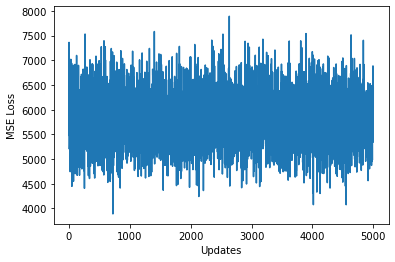

100%|██████████| 5000/5000 [07:07<00:00, 11.70it/s]


In [18]:
if torch.cuda.is_available():
    # check if a GPU is available for use with PyTorch
    device = "cuda" # device is set to "cuda"
else:
    device="cpu" # if not, it is set to "cpu"

# Sets a random seed
seed = 1
set_seed(seed)
# Defines the path where the results of the training will be saved.
results_path = os.path.join('./numerical_results/', "PDE_DGM", "seed{}".format(seed))
if not os.path.exists(results_path):
    os.makedirs(results_path)

# Calls the train function
train(T=1,
    n_steps=50,
    d=2,
    hidden_dim=100,
    max_updates=5000,
    batch_size=500,
    base_dir=results_path,
    device=device,
    )